In [1]:
from google.cloud import bigquery
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Concatenate
from tensorflow.keras.optimizers import Adam

from transformers import AutoTokenizer
from transformers import DistilBertForTokenClassification
from transformers import Trainer, TrainingArguments

import matplotlib.pyplot as plt
import seaborn as sns

E:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Reading data

In [8]:
kaggle_balance_transactions = pd.read_csv('./data/Kaggle/kaggle_eth_addresses.csv')

kaggle_balance_transactions

,Address,Name,Account Type,Contract Type,Entity,Label,Tags,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,Akropolis (AKRO),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,NaN,NaN,NaN,NaN
1,0x1c74cff0376fb4031cd7492cd6db2d66c3f2c6b9,bZx Protocol Token (BZRX),Smart Contract,Token,DeFi,Legit,Token Contract,bZx,DeFi,0x Ecosystem,Trading,Liquidity
2,0x06af07097c9eeb7fd685c692751d5c66db49c215,Chai (CHAI),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,Verified Contract,NaN,NaN,NaN
3,0xc00e94cb662c3520282e6f5717214004a7f26888,Compound (COMP),Smart Contract,Token,DeFi,Legit,DAO,Compound,Token Contract,NaN,NaN,NaN
4,0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407,Compound 0x (cZRX),Smart Contract,Token,DeFi,Legit,Token Contract,DeFi,Compound,0x Ecosystem,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19133,0xefa1994328e59f8e24d85458810d67a27289679a,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19134,0xf6c68965cdc903164284b482ef5dfdb640d9e0de,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19135,0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19136,0xfba9a978650672718e86c36018dcf92d85e108cf,NaN,Wallet,NaN,NaN,Legit,Pundi X,NaN,NaN,NaN,NaN,NaN


In [9]:
kaggle_balance_transactions['Tags'].unique()

array(['DeFi', 'Token Contract', 'DAO', 'Verified Contract',
       'NEST Protocol', 'Maker', 'Ren', 'Synthetix', 'Aave', 'Loans',
       'Zerion', 'Compound', 'Contract Deployer', 'DeFi Saver', 'dYdX',
       'Zapper.Fi', 'Gitcoin Grants', 'Uniswap', 'Kyber', 'mStable',
       'Dex', 'IDEX', 'Wallet App', 'Tags', 'ABCC', 'Exchange', 'Bgogo',
       'Binance', 'Derivatives', 'Fiat Gateway', 'Liqui.io', 'Bitfinex',
       'Bithumb', 'BitMart', 'BitMax.io', 'Bitstamp', 'Bittrex',
       'Cobinhood', 'Cold Wallet', 'Coinhako', 'CoinMetro', 'Coinone',
       'COSS.io', 'CREX24', 'DigiFinex', 'FTX', 'Gate.io', 'GBX',
       'Gemini', 'HitBTC', 'Hotbit', 'Huobi', 'Kraken', 'Kryptono',
       'KuCoin', 'LAToken', 'Liquid', 'OKEx', 'Paribu', 'Poloniex',
       'Remitano', 'ShapeShift', 'Options Trading', 'TAGZ', 'Tidex',
       'TopBTC', 'Trade.io', 'Upbit', 'YUNBI', 'ZB.com', 'ICO Wallets',
       'Bancor', 'Basic Attention Token', 'Etheroll', 'FOAM', 'Metronome',
       'Status', 'Cloud', 'S

# Since there is no ransomeware in this data, it is safe to assume label based on only to_address to find Dodgy labels.

In [10]:
kaggle_balance_transactions_addresses = kaggle_balance_transactions['Address']
kaggle_balance_transactions_addresses

0        0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7
1        0x1c74cff0376fb4031cd7492cd6db2d66c3f2c6b9
2        0x06af07097c9eeb7fd685c692751d5c66db49c215
3        0xc00e94cb662c3520282e6f5717214004a7f26888
4        0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407
                            ...                    
19133    0xefa1994328e59f8e24d85458810d67a27289679a
19134    0xf6c68965cdc903164284b482ef5dfdb640d9e0de
19135    0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52
19136    0xfba9a978650672718e86c36018dcf92d85e108cf
19137    0xfd2b3eb22bac1634f8b554a6d67fd11849dc3a0f
Name: Address, Length: 19138, dtype: object

In [5]:
# kaggle_balance_transactions_addresses.to_csv('Kaggle_addresses.csv')

Since the ratio is 97:3, aka around 2500 vs 87 per file, let's take all dodgy label from file 0->9, the new ratio will be 2500:870, aka 7:3, much better?

In [11]:
temp=kaggle_balance_transactions[kaggle_balance_transactions['Label'] == 'Dodgy']
temp

,Address,Name,Account Type,Contract Type,Entity,Label,Tags,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
2153,0xf2effc1cd320ff062bae8649d150dbea3cb6b189,Ethereum (ETH),Smart Contract,Token,NaN,Dodgy,Phish / Hack,NaN,NaN,NaN,NaN,NaN
2505,0x0f598112679b78e17a4a9febc83703710d33489c,Monero Gold (XMRG),Smart Contract,Token,NaN,Dodgy,Unsafe,NaN,NaN,NaN,NaN,NaN
2560,0x226c98fba127213154a121e9ebcfe73236e6f0dd,NKMS (NuCypher),Smart Contract,Token,NaN,Dodgy,Suspicious,NaN,NaN,NaN,NaN,NaN
2608,0xf31b4f7550833a746f788b36f2b292e5fa49a248,Paxos Standard Token (PAX),Smart Contract,Token,NaN,Dodgy,Phishing,Phish / Hack,NaN,NaN,NaN,NaN
2845,0x870cbbd204d5e2317c60374888e4b6be3bfa092b,Tellor (TRB),Smart Contract,Token,NaN,Dodgy,Phish / Hack,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19132,0xef5da7752c084df1cc719c64bbe06fa98b2c554c,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19133,0xefa1994328e59f8e24d85458810d67a27289679a,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19134,0xf6c68965cdc903164284b482ef5dfdb640d9e0de,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN
19135,0xf6e51ae30705cd7248d4d9ac602cb58cc4b61a52,NaN,Smart Contract,NaN,NaN,Dodgy,Parity Bug,NaN,NaN,NaN,NaN,NaN


In [6]:
kaggle_balance_transactions[kaggle_balance_transactions['Label'] == 'Legit']

,Address,Name,Account Type,Contract Type,Entity,Label,Tags,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,0x8ab7404063ec4dbcfd4598215992dc3f8ec853d7,Akropolis (AKRO),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,NaN,NaN,NaN,NaN
1,0x1c74cff0376fb4031cd7492cd6db2d66c3f2c6b9,bZx Protocol Token (BZRX),Smart Contract,Token,DeFi,Legit,Token Contract,bZx,DeFi,0x Ecosystem,Trading,Liquidity
2,0x06af07097c9eeb7fd685c692751d5c66db49c215,Chai (CHAI),Smart Contract,Token,DeFi,Legit,DeFi,Token Contract,Verified Contract,NaN,NaN,NaN
3,0xc00e94cb662c3520282e6f5717214004a7f26888,Compound (COMP),Smart Contract,Token,DeFi,Legit,DAO,Compound,Token Contract,NaN,NaN,NaN
4,0xb3319f5d18bc0d84dd1b4825dcde5d5f7266d407,Compound 0x (cZRX),Smart Contract,Token,DeFi,Legit,Token Contract,DeFi,Compound,0x Ecosystem,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
19104,0xd01c6a0e96f5143ac1a62edfe1dd0caef989225f,NaN,Wallet,NaN,NaN,Legit,Pundi X,NaN,NaN,NaN,NaN,NaN
19120,0xdede2674e56d558288bdaa25ce3699fe42697c4e,NaN,Wallet,NaN,NaN,Legit,Pundi X,NaN,NaN,NaN,NaN,NaN
19124,0xe0f5b79ef9f748562a21d017bb7a6706954b7585,NaN,Wallet,NaN,NaN,Legit,Liqui.io,NaN,NaN,NaN,NaN,NaN
19129,0xe92d1a43df510f82c66382592a047d288f85226f,NaN,Wallet,NaN,NaN,Legit,Liqui.io,NaN,NaN,NaN,NaN,NaN


In [12]:
def read_data(filename, x):
    if int(x) < 10:
        target_merged = temp
    else:
        target_merged = kaggle_balance_transactions
    
    frame = pd.read_csv(filename, index_col=None, header=0)
        
    # initialize an empty list to hold the results
    results = []
    chunksize = 100000

    # iterate over the frame data frame in chunks
    for i in tqdm(range(0, len(frame), chunksize)):
        chunk = frame[i:i+chunksize]

        # merge the kaggle_balance_transactions data frame with the current chunk
#         merged_df = pd.merge(chunk, target_merged, right_on=['Address'], left_on=['from_address'], how='left', suffixes=('_kbt', '_frame'))
        merged_df = pd.merge(chunk, target_merged, right_on=['Address'], left_on=['to_address'], how='left', suffixes=('_kbt', '_frame'))

        # append the results to the list
        results.append(merged_df)

    # concatenate the results into a single data frame
    merged_df = pd.concat(results)

    # drop duplicates
    merged_df.drop_duplicates(inplace=True)
#     print (merged_df.columns)

    # select the columns you want to keep
    columns_to_keep = ['Account Type', 'Label', 'Tags'] + ['value', 'gas', 'block_timestamp',
        'receipt_cumulative_gas_used', #'gas_price_frame',
#            'receipt_gas_used_frame', 'receipt_contract_address_frame',
#            'receipt_root_frame', 'receipt_status_frame', 
#            'block_number_frame', 'block_hash_frame', 'max_fee_per_gas_frame',
#            'max_priority_fee_per_gas_frame', 'transaction_type_frame', 'input_frame',
       'receipt_effective_gas_price', 'address', 'from_address', 'to_address', 
       'eth_balance']

    # create a new data frame with only the columns you want to keep
    new_df = merged_df[columns_to_keep]
    
    # drop rows where Account Type is NaN
    new_df.dropna(subset=['Account Type'], inplace=True)
    new_df = new_df[new_df['Label'] != 'Label']
    
    return new_df

# Due to Jupyter Notebook mechanism, cannot read 2 files under 1 cell, otherwise memory constraint localy
for x in range(23):
    if x < 10:
        x = '0' + str(x)
        
    fileName = './data/Kaggle/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv'
    curr_file = read_data(fileName, x)
    curr_file.to_csv('./output/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv', index=False)
    
# new_df

C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:7: DtypeWarning: Columns (11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, index_col=None, header=0)
100%|██████████| 9/9 [00:00<00:00, 16.30it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=['Account Type'], inplace=True)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:7: DtypeWarning: Columns (11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, index_col=None, header=0)
100%|██████████| 9/9 [00:00<00:00, 15.14it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:45: SettingWithCopyWarning

C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:7: DtypeWarning: Columns (5,11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, index_col=None, header=0)
100%|██████████| 9/9 [00:00<00:00, 17.09it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.dropna(subset=['Account Type'], inplace=True)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:7: DtypeWarning: Columns (5,11,12,22) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(filename, index_col=None, header=0)
100%|██████████| 9/9 [00:00<00:00, 17.24it/s]
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\4069267454.py:45: SettingWithCopyWar

In [13]:
new_df = pd.read_csv('./output/kaggle_10k_balance_transaction_000000000000.csv', index_col=None, header=0)
for x in range(1, 23):
    if x < 10:
        x = '0' + str(x)
        
    fileName = './output/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv'
    df_file = pd.read_csv(fileName, index_col = None, header = 0)
    new_df = pd.concat([new_df, df_file], ignore_index=True)
    
# new_df = pd.read_csv('./temp/kaggle_10k_balance_transaction_000000000000.csv', index_col=None, header=0)
# for x in range(1, 20):
#     if x < 10:
#         x = '0' + str(x)
        
#     fileName = './temp/kaggle_10k_balance_transaction_0000000000' + str(x) + '.csv'
#     df_file = pd.read_csv(fileName, index_col = None, header = 0)
#     new_df = pd.concat([new_df, df_file], ignore_index=True)

new_df.columns

C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\2289260587.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(fileName, index_col = None, header = 0)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\2289260587.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(fileName, index_col = None, header = 0)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\2289260587.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(fileName, index_col = None, header = 0)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\2289260587.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_file = pd.read_csv(fileName, index_col = None, header = 0)
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\2289260587.py:7: Dtype

Index(['Account Type', 'Label', 'Tags', 'value', 'gas', 'block_timestamp',
       'receipt_cumulative_gas_used', 'receipt_effective_gas_price', 'address',
       'from_address', 'to_address', 'eth_balance'],
      dtype='object')

In [8]:
new_df

,Account Type,Label,Tags,value,gas,block_timestamp,receipt_cumulative_gas_used,receipt_effective_gas_price,address,from_address,to_address,eth_balance
0,Smart Contract,Dodgy,Website Down,0,70000,2018-11-01 09:35:35 UTC,4247979,6000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xcb8da6cb6d8cb4c50b0f07b7f9754f8f92986b96,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783
1,Smart Contract,Dodgy,Website Down,0,70000,2018-11-02 16:37:11 UTC,842167,25000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xdc52ebcf077e64076321772ef39eb336a27f8d12,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783
2,Smart Contract,Dodgy,Scamming,100000000000000000,1200000,2017-10-30 11:24:09 UTC,2604500,4000000000,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,0x9be06e66abadf056cea6674d532c13e7500ff7e7,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,27000000000000000
3,Smart Contract,Dodgy,Phishing,0,53475,2018-04-14 02:35:48 UTC,260222,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0
4,Smart Contract,Dodgy,Phishing,0,53475,2018-04-14 02:33:14 UTC,4778849,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7660781,Smart Contract,Legit,Token Contract,0,150000,2017-12-30 23:15:01 UTC,1373333,22000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660782,Smart Contract,Legit,Token Contract,0,150000,2017-12-19 02:53:45 UTC,4844900,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660783,Smart Contract,Legit,Token Contract,0,150000,2017-12-25 03:06:13 UTC,2011578,23100000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660784,Smart Contract,Legit,Token Contract,0,150000,2017-12-19 00:35:11 UTC,2084553,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0


In [11]:
# # df_file2 = read_data(fileName2)
# # new_df = pd.concat([df_file1, df_file2])
# new_df = df_file1
# print (new_df.head(3))
# print('--------------------------------------------------------------------')
print ("Data label distribution check")
print ("Data account type distribution check")

labels_dict = dict()
account_type_dict = dict()
for row in tqdm(new_df.iterrows()):
#     print (row[1]['Label'])
    label_val = row[1]['Label']
    if label_val not in labels_dict.keys():
        labels_dict[label_val] = 1
    else:
        labels_dict[label_val] += 1
        
    account_type_val = row[1]['Account Type']
    if account_type_val not in account_type_dict.keys():
        account_type_dict[account_type_val] = 1
    else:
        account_type_dict[account_type_val] += 1
        
print (labels_dict)
print (account_type_dict)

Data label distribution check
Data account type distribution check


7660786it [03:28, 36700.40it/s]

{'Dodgy': 211693, 'Legit': 7449093}
{'Smart Contract': 6462836, 'Wallet': 1197950}


Ratio between Dodgy and Legit is 3:97

# Preprocessing Data

In [9]:
# Preprocessing of each columns
for column in new_df.columns:
    if column != 'Label':
        unique_val = new_df[column].unique()
        print ("Column: ", column)

        if new_df[column].dtypes == 'int64':
            new_df[column] = new_df[column].fillna(0)
        else:
            new_df[column] = new_df[column].astype(str)
            new_df[column] = new_df[column].fillna('unknown')
            
new_df

Column:  Account Type
Column:  Tags
Column:  value
Column:  gas
Column:  block_timestamp
Column:  receipt_cumulative_gas_used
Column:  receipt_effective_gas_price
Column:  address
Column:  from_address
Column:  to_address
Column:  eth_balance


,Account Type,Label,Tags,value,gas,block_timestamp,receipt_cumulative_gas_used,receipt_effective_gas_price,address,from_address,to_address,eth_balance
0,Smart Contract,Dodgy,Website Down,0,70000,2018-11-01 09:35:35 UTC,4247979,6000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xcb8da6cb6d8cb4c50b0f07b7f9754f8f92986b96,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783
1,Smart Contract,Dodgy,Website Down,0,70000,2018-11-02 16:37:11 UTC,842167,25000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xdc52ebcf077e64076321772ef39eb336a27f8d12,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783
2,Smart Contract,Dodgy,Scamming,100000000000000000,1200000,2017-10-30 11:24:09 UTC,2604500,4000000000,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,0x9be06e66abadf056cea6674d532c13e7500ff7e7,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,27000000000000000
3,Smart Contract,Dodgy,Phishing,0,53475,2018-04-14 02:35:48 UTC,260222,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0
4,Smart Contract,Dodgy,Phishing,0,53475,2018-04-14 02:33:14 UTC,4778849,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7660781,Smart Contract,Legit,Token Contract,0,150000,2017-12-30 23:15:01 UTC,1373333,22000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660782,Smart Contract,Legit,Token Contract,0,150000,2017-12-19 02:53:45 UTC,4844900,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660783,Smart Contract,Legit,Token Contract,0,150000,2017-12-25 03:06:13 UTC,2011578,23100000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0
7660784,Smart Contract,Legit,Token Contract,0,150000,2017-12-19 00:35:11 UTC,2084553,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0


In [10]:
# Remove the Tag class with below 10 count, as mentioned later
counts = new_df['Tags'].value_counts()

temp_df = new_df[new_df['Tags'].isin(counts[counts <= 10].index)]
print (temp_df['Tags'])

new_df = new_df[new_df['Tags'].isin(counts[counts > 10].index)] # 10 is cutof as mentioned in Preprocessing step

15          Spam Token
2564          Fake ICO
18328      bZx Exploit
27452       Spam Token
30127       Spam Token
              ...     
6735890         Oracle
7307951           Band
7318098         Oracle
7357514     0xUniverse
7658410       Remitano
Name: Tags, Length: 92, dtype: object


In [11]:
for val in (np.unique(temp_df['Tags'])):
    print (val)

0xUniverse
ABCC
Band
Bridge
Bugs
CoinMetro
CryptoBots
DeFi Saver
Fake ICO
GBX
HitBTC
Hotbit
Loopring
Marketing
OTC
Oracle
POA Network
PoolTogether
Remitano
Spam Token
Status
Streaming
Surveillance
Swipe.io
White Hat Group
bZx Exploit
dForce
tBTC


In [12]:
#Encode categorical columns:
encoder = LabelEncoder()
encoder_tags = LabelEncoder()
categorical_columns = ['Account Type', 'Tags']
for col in categorical_columns:
    if col == "Tags":
        new_df['encoded_tags'] = encoder_tags.fit_transform(new_df[col])
    else:
        new_df[col] = encoder.fit_transform(new_df[col])

# Target Label column encoder
new_df['encoded_label'] = encoder.fit_transform(new_df['Label'])
new_df = new_df.drop('Label', axis=1)

new_df

C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1674964004.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = encoder.fit_transform(new_df[col])
C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1674964004.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['encoded_tags'] = encoder_tags.fit_transform(new_df[col])
C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1674964004.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

,Account Type,Tags,value,gas,block_timestamp,receipt_cumulative_gas_used,receipt_effective_gas_price,address,from_address,to_address,eth_balance,encoded_tags,encoded_label
0,0,Website Down,0,70000,2018-11-01 09:35:35 UTC,4247979,6000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xcb8da6cb6d8cb4c50b0f07b7f9754f8f92986b96,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783,213,0
1,0,Website Down,0,70000,2018-11-02 16:37:11 UTC,842167,25000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xdc52ebcf077e64076321772ef39eb336a27f8d12,0x02c60d28be3338014fef3fdf50a3218b946c0609,2531819961254783,213,0
2,0,Scamming,100000000000000000,1200000,2017-10-30 11:24:09 UTC,2604500,4000000000,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,0x9be06e66abadf056cea6674d532c13e7500ff7e7,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,27000000000000000,170,0
3,0,Phishing,0,53475,2018-04-14 02:35:48 UTC,260222,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0,153,0
4,0,Phishing,0,53475,2018-04-14 02:33:14 UTC,4778849,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0,153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660781,0,Token Contract,0,150000,2017-12-30 23:15:01 UTC,1373333,22000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0,194,1
7660782,0,Token Contract,0,150000,2017-12-19 02:53:45 UTC,4844900,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0,194,1
7660783,0,Token Contract,0,150000,2017-12-25 03:06:13 UTC,2011578,23100000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0,194,1
7660784,0,Token Contract,0,150000,2017-12-19 00:35:11 UTC,2084553,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0,194,1


In [13]:
# add a new column to calculate transaction amount in USD
eth_usd_price = 1840  # the ETH/USD price at the time of this code
df = new_df

# convert value from wei to ETH
df['value'] = pd.to_numeric(df['value'], errors='coerce') #/ 10**18
df['eth_balance'] = pd.to_numeric(df['eth_balance'], errors='coerce')
# df['USD_value'] = df['value_frame'] * eth_usd_price
df

,Account Type,Tags,value,gas,block_timestamp,receipt_cumulative_gas_used,receipt_effective_gas_price,address,from_address,to_address,eth_balance,encoded_tags,encoded_label
0,0,Website Down,0.000000e+00,70000,2018-11-01 09:35:35 UTC,4247979,6000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xcb8da6cb6d8cb4c50b0f07b7f9754f8f92986b96,0x02c60d28be3338014fef3fdf50a3218b946c0609,2.531820e+15,213,0
1,0,Website Down,0.000000e+00,70000,2018-11-02 16:37:11 UTC,842167,25000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xdc52ebcf077e64076321772ef39eb336a27f8d12,0x02c60d28be3338014fef3fdf50a3218b946c0609,2.531820e+15,213,0
2,0,Scamming,1.000000e+17,1200000,2017-10-30 11:24:09 UTC,2604500,4000000000,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,0x9be06e66abadf056cea6674d532c13e7500ff7e7,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,2.700000e+16,170,0
3,0,Phishing,0.000000e+00,53475,2018-04-14 02:35:48 UTC,260222,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0.000000e+00,153,0
4,0,Phishing,0.000000e+00,53475,2018-04-14 02:33:14 UTC,4778849,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0.000000e+00,153,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660781,0,Token Contract,0.000000e+00,150000,2017-12-30 23:15:01 UTC,1373333,22000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1
7660782,0,Token Contract,0.000000e+00,150000,2017-12-19 02:53:45 UTC,4844900,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1
7660783,0,Token Contract,0.000000e+00,150000,2017-12-25 03:06:13 UTC,2011578,23100000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1
7660784,0,Token Contract,0.000000e+00,150000,2017-12-19 00:35:11 UTC,2084553,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1


In [14]:
df['received_value'] = df.apply(lambda row: row['value'] if row['to_address'] == row['address'] else 0, axis=1)
df['sent_value'] = df.apply(lambda row: row['value'] if row['from_address'] == row['address'] else 0, axis=1)

# calculate number of withdrawals and deposits
df['num_withdrawals'] = df.apply(lambda row: 1 if row['from_address'] == row['address'] else 0, axis=1)
df['num_deposits'] = df.apply(lambda row: 1 if row['to_address'] == row['address'] else 0, axis=1)

df

,Account Type,Tags,value,gas,block_timestamp,receipt_cumulative_gas_used,receipt_effective_gas_price,address,from_address,to_address,eth_balance,encoded_tags,encoded_label,received_value,sent_value,num_withdrawals,num_deposits
0,0,Website Down,0.000000e+00,70000,2018-11-01 09:35:35 UTC,4247979,6000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xcb8da6cb6d8cb4c50b0f07b7f9754f8f92986b96,0x02c60d28be3338014fef3fdf50a3218b946c0609,2.531820e+15,213,0,0.000000e+00,0.0,0,1
1,0,Website Down,0.000000e+00,70000,2018-11-02 16:37:11 UTC,842167,25000000000,0x02c60d28be3338014fef3fdf50a3218b946c0609,0xdc52ebcf077e64076321772ef39eb336a27f8d12,0x02c60d28be3338014fef3fdf50a3218b946c0609,2.531820e+15,213,0,0.000000e+00,0.0,0,1
2,0,Scamming,1.000000e+17,1200000,2017-10-30 11:24:09 UTC,2604500,4000000000,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,0x9be06e66abadf056cea6674d532c13e7500ff7e7,0x0a4a2413d7c604647c7788fd3564b3c54fe06763,2.700000e+16,170,0,1.000000e+17,0.0,0,1
3,0,Phishing,0.000000e+00,53475,2018-04-14 02:35:48 UTC,260222,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0.000000e+00,153,0,0.000000e+00,0.0,0,1
4,0,Phishing,0.000000e+00,53475,2018-04-14 02:33:14 UTC,4778849,1000000000,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0x02ad50db5d2eafa0bd66aabca67bcb8485eeaad9,0x0d4f74c538613ed6e6c8c1bc8896ecfd45f5ef23,0.000000e+00,153,0,0.000000e+00,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660781,0,Token Contract,0.000000e+00,150000,2017-12-30 23:15:01 UTC,1373333,22000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1,0.000000e+00,0.0,0,1
7660782,0,Token Contract,0.000000e+00,150000,2017-12-19 02:53:45 UTC,4844900,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1,0.000000e+00,0.0,0,1
7660783,0,Token Contract,0.000000e+00,150000,2017-12-25 03:06:13 UTC,2011578,23100000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x0a73573cf2903d2d8305b1ecb9e9730186a312ae,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1,0.000000e+00,0.0,0,1
7660784,0,Token Contract,0.000000e+00,150000,2017-12-19 00:35:11 UTC,2084553,21000000000,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0x4b01721f0244e7c5b5f63c20942850e447f5a5ee,0xff18dbc487b4c2e3222d115952babfda8ba52f5f,0.000000e+00,194,1,0.000000e+00,0.0,0,1


In [15]:
agg_dict = {
    'block_timestamp': ['min', 'max'], 
    'receipt_effective_gas_price': ['count'],
    'from_address': pd.Series.nunique, 
    'to_address': pd.Series.nunique,
    'eth_balance': ['last'],
    'received_value': ['sum'],
    'sent_value': ['sum'],
    'num_withdrawals': ['sum'],
    'num_deposits': ['sum']
}
grouped = df.groupby('address').agg(agg_dict)

grouped

block_timestamp  \
                                                                min   
address                                                               
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2020-05-25 14:27:51 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2019-09-13 14:15:32 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2018-12-18 03:54:10 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2019-01-11 21:26:56 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2019-01-04 04:54:34 UTC   
...                                                             ...   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2020-01-13 11:19:46 UTC   
0xffda12355351d1daf2ac3fd42206a64425a4dd06  2019-11-16 19:21:42 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89  2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2018-05-01 04:28:03 UTC   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb  2019-08-23 11:42:24 UTC   

                                                                     \
                                                                max   
address                                                               
0x0000000000004946c0e9f43f4dee607b0ef1fa1c  2023-04-25 00:33:23 UTC   
0x000000000000541e251335090ac5b47176af4f7e  2021-11-12 21:33:38 UTC   
0x0000000000013949f288172bd7e36837bddc7211  2020-08-26 23:33:48 UTC   
0x0000000000075efbee23fe2de1bd0b7690883cc9  2023-05-01 15:44:11 UTC   
0x0000000000085d4780b73119b644ae5ecd22b376  2023-05-01 17:00:11 UTC   
...                                                             ...   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90  2021-05-20 06:48:28 UTC   
0xffda12355351d1daf2ac3fd42206a64425a4dd06  2019-11-29 20:24:23 UTC   
0xffe4ea384e13295bf74a515a36f552313fb25a89  2020-04-28 02:30:26 UTC   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4  2023-05-01 15:29:23 UTC   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb  2019-12-08 08:19:43 UTC   

                                           receipt_effective_gas_price  \
                                                                 count   
address                                                                  
0x0000000000004946c0e9f43f4dee607b0ef1fa1c                        3384   
0x000000000000541e251335090ac5b47176af4f7e                         499   
0x0000000000013949f288172bd7e36837bddc7211                         232   
0x0000000000075efbee23fe2de1bd0b7690883cc9                         921   
0x0000000000085d4780b73119b644ae5ecd22b376                       31994   
...                                                                ...   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90                          40   
0xffda12355351d1daf2ac3fd42206a64425a4dd06                           3   
0xffe4ea384e13295bf74a515a36f552313fb25a89                           1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4                       33843   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb                           8   

                                           from_address to_address  \
                                                nunique    nunique   
address                                                              
0x0000000000004946c0e9f43f4dee607b0ef1fa1c         1771          1   
0x000000000000541e251335090ac5b47176af4f7e           72          1   
0x0000000000013949f288172bd7e36837bddc7211            7          1   
0x0000000000075efbee23fe2de1bd0b7690883cc9           14          1   
0x0000000000085d4780b73119b644ae5ecd22b376        11423          1   
...                                                 ...        ...   
0xffa9817f20ab5742ad016e094b42716cdd4fcb90           20          1   
0xffda12355351d1daf2ac3fd42206a64425a4dd06            3          1   
0xffe4ea384e13295bf74a515a36f552313fb25a89            1          1   
0xffec0067f5a79cff07527f63d83dd5462ccf8ba4            4         24   
0xfffab974088bd5bf3d7e6f522e93dd7861264cdb            7          1   

                                            

!!!!!!!! We have 4422  unique addresses in training data

In [16]:
# flatten the column names after aggregation
grouped.columns = ['_'.join(col).rstrip('_') for col in grouped.columns.values]

grouped

,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum
address,,,,,,,,,,
0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51 UTC,2023-04-25 00:33:23 UTC,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384
0x000000000000541e251335090ac5b47176af4f7e,2019-09-13 14:15:32 UTC,2021-11-12 21:33:38 UTC,499,72,1,1.016206e+19,1.986065e+20,0.0,0,499
0x0000000000013949f288172bd7e36837bddc7211,2018-12-18 03:54:10 UTC,2020-08-26 23:33:48 UTC,232,7,1,0.000000e+00,0.000000e+00,0.0,0,232
0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-01-11 21:26:56 UTC,2023-05-01 15:44:11 UTC,921,14,1,0.000000e+00,0.000000e+00,0.0,0,921
0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 04:54:34 UTC,2023-05-01 17:00:11 UTC,31994,11423,1,0.000000e+00,0.000000e+00,0.0,0,31994
...,...,...,...,...,...,...,...,...,...,...
0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-13 11:19:46 UTC,2021-05-20 06:48:28 UTC,40,20,1,0.000000e+00,0.000000e+00,0.0,0,40
0xffda12355351d1daf2ac3fd42206a64425a4dd06,2019-11-16 19:21:42 UTC,2019-11-29 20:24:23 UTC,3,3,1,0.000000e+00,5.000000e+17,0.0,0,3
0xffe4ea384e13295bf74a515a36f552313fb25a89,2020-04-28 02:30:26 UTC,2020-04-28 02:30:26 UTC,1,1,1,0.000000e+00,4.000000e+17,0.0,0,1


In [17]:
# calculate highest received USD
grouped['highest_transaction_value'] = df.groupby('address')['value'].max()


grouped.describe()

,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
count,4.630000e+03,4630.000000,4630.000000,4.630000e+03,4.630000e+03,4.630000e+03,4630.000000,4.630000e+03,4.630000e+03
mean,1.654578e+03,658.750324,2.129806,1.506607e+21,5.387288e+21,1.250796e+21,162.898488,1.491737e+03,1.311774e+21
std,2.777721e+04,11711.816343,10.965125,6.148397e+22,7.220160e+22,2.593941e+22,2909.238713,2.760130e+04,2.199619e+22
min,1.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
25%,2.000000e+00,1.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+00,0.000000e+00
50%,1.200000e+01,5.000000,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.000000e+01,0.000000e+00
75%,1.370000e+02,56.000000,1.000000,0.000000e+00,6.089600e+17,0.000000e+00,0.000000,1.240000e+02,5.519090e+17
max,1.591443e+06,578330.000000,282.000000,3.631147e+24,2.205446e+24,8.500000e+23,96253.000000,1.591443e+06,7.895246e+23


In [18]:
from dateutil.parser import parse

# convert block_timestamp to datetime format
grouped.dropna(subset=['block_timestamp_min'], inplace=True)
grouped.dropna(subset=['block_timestamp_max'], inplace=True)
grouped = grouped.reset_index(drop=False)

grouped

,address,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51 UTC,2023-04-25 00:33:23 UTC,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-13 14:15:32 UTC,2021-11-12 21:33:38 UTC,499,72,1,1.016206e+19,1.986065e+20,0.0,0,499,1.100000e+20
2,0x0000000000013949f288172bd7e36837bddc7211,2018-12-18 03:54:10 UTC,2020-08-26 23:33:48 UTC,232,7,1,0.000000e+00,0.000000e+00,0.0,0,232,0.000000e+00
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-01-11 21:26:56 UTC,2023-05-01 15:44:11 UTC,921,14,1,0.000000e+00,0.000000e+00,0.0,0,921,0.000000e+00
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 04:54:34 UTC,2023-05-01 17:00:11 UTC,31994,11423,1,0.000000e+00,0.000000e+00,0.0,0,31994,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
4625,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-13 11:19:46 UTC,2021-05-20 06:48:28 UTC,40,20,1,0.000000e+00,0.000000e+00,0.0,0,40,0.000000e+00
4626,0xffda12355351d1daf2ac3fd42206a64425a4dd06,2019-11-16 19:21:42 UTC,2019-11-29 20:24:23 UTC,3,3,1,0.000000e+00,5.000000e+17,0.0,0,3,3.000000e+17
4627,0xffe4ea384e13295bf74a515a36f552313fb25a89,2020-04-28 02:30:26 UTC,2020-04-28 02:30:26 UTC,1,1,1,0.000000e+00,4.000000e+17,0.0,0,1,4.000000e+17
4628,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03 UTC,2023-05-01 15:29:23 UTC,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20


In [19]:
grouped = grouped.drop(grouped.index[-1])
grouped['block_timestamp_min'] = grouped['block_timestamp_min'].apply(lambda x: parse(x))
grouped['block_timestamp_max'] = grouped['block_timestamp_max'].apply(lambda x: parse(x))

grouped

,address,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-13 14:15:32+00:00,2021-11-12 21:33:38+00:00,499,72,1,1.016206e+19,1.986065e+20,0.0,0,499,1.100000e+20
2,0x0000000000013949f288172bd7e36837bddc7211,2018-12-18 03:54:10+00:00,2020-08-26 23:33:48+00:00,232,7,1,0.000000e+00,0.000000e+00,0.0,0,232,0.000000e+00
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-01-11 21:26:56+00:00,2023-05-01 15:44:11+00:00,921,14,1,0.000000e+00,0.000000e+00,0.0,0,921,0.000000e+00
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 04:54:34+00:00,2023-05-01 17:00:11+00:00,31994,11423,1,0.000000e+00,0.000000e+00,0.0,0,31994,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...
4624,0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a,2019-10-24 15:38:58+00:00,2019-10-24 15:38:58+00:00,1,1,1,0.000000e+00,2.000000e+16,0.0,0,1,2.000000e+16
4625,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-13 11:19:46+00:00,2021-05-20 06:48:28+00:00,40,20,1,0.000000e+00,0.000000e+00,0.0,0,40,0.000000e+00
4626,0xffda12355351d1daf2ac3fd42206a64425a4dd06,2019-11-16 19:21:42+00:00,2019-11-29 20:24:23+00:00,3,3,1,0.000000e+00,5.000000e+17,0.0,0,3,3.000000e+17
4627,0xffe4ea384e13295bf74a515a36f552313fb25a89,2020-04-28 02:30:26+00:00,2020-04-28 02:30:26+00:00,1,1,1,0.000000e+00,4.000000e+17,0.0,0,1,4.000000e+17


In [20]:
# calculate mean time between transactions
grouped['mean_time_between_transactions'] = (
    grouped['block_timestamp_max'] - grouped['block_timestamp_min']) / grouped['receipt_effective_gas_price_count']
grouped['mean_time_between_transactions'] = grouped['mean_time_between_transactions'].apply(lambda x: x.total_seconds())

# calculate lifetime of each address
grouped['lifetime'] = (grouped['block_timestamp_max'] - grouped['block_timestamp_min']).apply(lambda x: x.total_seconds())

grouped

,address,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,2.717669e+04,91965932.0
1,0x000000000000541e251335090ac5b47176af4f7e,2019-09-13 14:15:32+00:00,2021-11-12 21:33:38+00:00,499,72,1,1.016206e+19,1.986065e+20,0.0,0,499,1.100000e+20,1.370114e+05,68368686.0
2,0x0000000000013949f288172bd7e36837bddc7211,2018-12-18 03:54:10+00:00,2020-08-26 23:33:48+00:00,232,7,1,0.000000e+00,0.000000e+00,0.0,0,232,0.000000e+00,2.300844e+05,53379578.0
3,0x0000000000075efbee23fe2de1bd0b7690883cc9,2019-01-11 21:26:56+00:00,2023-05-01 15:44:11+00:00,921,14,1,0.000000e+00,0.000000e+00,0.0,0,921,0.000000e+00,1.473549e+05,135713835.0
4,0x0000000000085d4780b73119b644ae5ecd22b376,2019-01-04 04:54:34+00:00,2023-05-01 17:00:11+00:00,31994,11423,1,0.000000e+00,0.000000e+00,0.0,0,31994,0.000000e+00,4.262760e+03,136382737.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4624,0xffa8b9cdb3b5d97c43191975f2f8111b164ef32a,2019-10-24 15:38:58+00:00,2019-10-24 15:38:58+00:00,1,1,1,0.000000e+00,2.000000e+16,0.0,0,1,2.000000e+16,0.000000e+00,0.0
4625,0xffa9817f20ab5742ad016e094b42716cdd4fcb90,2020-01-13 11:19:46+00:00,2021-05-20 06:48:28+00:00,40,20,1,0.000000e+00,0.000000e+00,0.0,0,40,0.000000e+00,1.064473e+06,42578922.0
4626,0xffda12355351d1daf2ac3fd42206a64425a4dd06,2019-11-16 19:21:42+00:00,2019-11-29 20:24:23+00:00,3,3,1,0.000000e+00,5.000000e+17,0.0,0,3,3.000000e+17,3.756537e+05,1126961.0
4627,0xffe4ea384e13295bf74a515a36f552313fb25a89,2020-04-28 02:30:26+00:00,2020-04-28 02:30:26+00:00,1,1,1,0.000000e+00,4.000000e+17,0.0,0,1,4.000000e+17,0.000000e+00,0.0


In [21]:
merged_df = grouped.merge(df[['address', 'Account Type', 'Tags', 'encoded_label', 'encoded_tags']], on='address', how='left')
merged_df

,address,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime,Account Type,Tags,encoded_label,encoded_tags
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,91965932.0,0,Token Contract,1,194
1,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,91965932.0,0,Token Contract,1,194
2,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,91965932.0,0,Token Contract,1,194
3,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,91965932.0,0,Token Contract,1,194
4,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,91965932.0,0,Token Contract,1,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660681,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,157806080.0,0,Stablecoin,1,184
7660682,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,157806080.0,0,Stablecoin,1,184
7660683,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,157806080.0,0,Stablecoin,1,184
7660684,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,157806080.0,0,Token Contract,1,194


In [22]:
merged_df.to_csv("./output/addresses_transaction_data.csv", index=False)

Feature engineering for Tag

In [23]:
from pandas.tseries.offsets import MonthEnd

In [24]:
# Convert block_timestamp_frame to datetime and calculate the end of month timestamp
df['block_timestamp'] = pd.to_datetime(df['block_timestamp'])
df['EndOfMonth'] = df['block_timestamp'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)

# Group by Tags
grouped = df.groupby('Tags')

C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\3038094891.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['EndOfMonth'] = df['block_timestamp'].dt.to_period('M').dt.to_timestamp('M') + MonthEnd(1)


In [25]:
# For each known tag Cluster:
stats = pd.DataFrame()

# Mean # of transactions
stats['MeanNumTransactions'] = grouped['value'].count()

# Mean balance
stats['MeanBalance'] = grouped['eth_balance'].mean()

# Standard Deviation balance
stats['StdDevBalance'] = grouped['eth_balance'].std()
stats

,MeanNumTransactions,MeanBalance,StdDevBalance
Tags,,,
0x,23237,9.847580e+11,1.501134e+14
0x Ecosystem,28621,6.563401e+15,1.308716e+17
Advertising,14599,7.921741e+20,2.813116e+21
AirSwap,12,2.475202e+15,8.236446e+15
Airdrop / Distributor,1875,1.384888e+19,3.189882e+20
...,...,...,...
Zapper.Fi,55,1.806910e+13,1.340040e+14
Zethr,179,0.000000e+00,0.000000e+00
dYdX,316,4.906346e+15,4.323809e+16


In [26]:
# Cluster lifetime (average of nodes)
stats['ClusterLifetime'] = grouped['block_timestamp'].apply(lambda x: (x.max() - x.min()).days)
stats

,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime
Tags,,,,
0x,23237,9.847580e+11,1.501134e+14,1204
0x Ecosystem,28621,6.563401e+15,1.308716e+17,2079
Advertising,14599,7.921741e+20,2.813116e+21,2112
AirSwap,12,2.475202e+15,8.236446e+15,304
Airdrop / Distributor,1875,1.384888e+19,3.189882e+20,1859
...,...,...,...,...
Zapper.Fi,55,1.806910e+13,1.340040e+14,209
Zethr,179,0.000000e+00,0.000000e+00,9
dYdX,316,4.906346e+15,4.323809e+16,627


In [27]:
# Mean activity:
## Number of withdrawals / month
stats['NumWithdrawalsPerMonth'] = grouped.apply(lambda x: x['num_withdrawals'].sum() / len(x['EndOfMonth'].unique()))

## Number of deposits / month
stats['NumDepositsPerMonth'] = grouped.apply(lambda x: x['num_deposits'].sum() / len(x['EndOfMonth'].unique()))

stats

,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth
Tags,,,,,,
0x,23237,9.847580e+11,1.501134e+14,1204,0.025000,580.900000
0x Ecosystem,28621,6.563401e+15,1.308716e+17,2079,6.869565,407.927536
Advertising,14599,7.921741e+20,2.813116e+21,2112,24.785714,183.771429
AirSwap,12,2.475202e+15,8.236446e+15,304,0.222222,1.111111
Airdrop / Distributor,1875,1.384888e+19,3.189882e+20,1859,3.349206,26.412698
...,...,...,...,...,...,...
Zapper.Fi,55,1.806910e+13,1.340040e+14,209,0.125000,6.750000
Zethr,179,0.000000e+00,0.000000e+00,9,0.000000,89.500000
dYdX,316,4.906346e+15,4.323809e+16,627,0.352941,18.235294


In [28]:
# Mean transaction data/ lifetime:
## Mean of received ETH / cluster lifetime
stats['MeanReceivedETHPerLifetime'] = grouped.apply(lambda x: x['received_value'].sum() / (x['block_timestamp'].max() - x['block_timestamp'].min()).days)

## Mean of sent ETH / cluster lifetime
stats['MeanSentETHPerLifetime'] = grouped.apply(lambda x: x['sent_value'].sum() / (x['block_timestamp'].max() - x['block_timestamp'].min()).days)

## Mean time between transactions
stats['MeanTimeBetweenTransactions'] = grouped['block_timestamp'].apply(lambda x: x.sort_values().diff().mean().total_seconds()/60)
stats

,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
Tags,,,,,,,,,
0x,23237,9.847580e+11,1.501134e+14,1204,0.025000,580.900000,2.341686e+16,3.737542e+12,74.651446
0x Ecosystem,28621,6.563401e+15,1.308716e+17,2079,6.869565,407.927536,0.000000e+00,0.000000e+00,104.605432
Advertising,14599,7.921741e+20,2.813116e+21,2112,24.785714,183.771429,6.717573e+17,0.000000e+00,208.342720
AirSwap,12,2.475202e+15,8.236446e+15,304,0.222222,1.111111,0.000000e+00,0.000000e+00,39915.960606
Airdrop / Distributor,1875,1.384888e+19,3.189882e+20,1859,3.349206,26.412698,1.377889e+18,5.379236e+12,1429.027535
...,...,...,...,...,...,...,...,...,...
Zapper.Fi,55,1.806910e+13,1.340040e+14,209,0.125000,6.750000,4.098660e+17,0.000000e+00,5590.287654
Zethr,179,0.000000e+00,0.000000e+00,9,0.000000,89.500000,6.906939e+19,0.000000e+00,77.907491
dYdX,316,4.906346e+15,4.323809e+16,627,0.352941,18.235294,1.042997e+18,1.227441e+18,2870.397354


In [29]:
# Reset the index in stats dataframe
stats_reset = stats.reset_index()

# Merge stats with merged_df
final_df = pd.merge(merged_df, stats_reset, left_on='Tags', right_on='Tags', how='left')
final_df

,address,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,from_address_nunique,to_address_nunique,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,...,encoded_tags,MeanNumTransactions,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions
0,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865
1,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865
2,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865
3,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865
4,0x0000000000004946c0e9f43f4dee607b0ef1fa1c,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,1771,1,0.000000e+00,6.000000e+17,0.0,0,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660681,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,...,184,1262451,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884
7660682,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,...,184,1262451,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884
7660683,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,...,184,1262451,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884
7660684,0xffec0067f5a79cff07527f63d83dd5462ccf8ba4,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,4,24,2.056215e+20,7.000000e+20,0.0,33840,...,194,972584,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865


In [30]:
final_df.columns

Index(['address', 'block_timestamp_min', 'block_timestamp_max',
       'receipt_effective_gas_price_count', 'from_address_nunique',
       'to_address_nunique', 'eth_balance_last', 'received_value_sum',
       'sent_value_sum', 'num_withdrawals_sum', 'num_deposits_sum',
       'highest_transaction_value', 'mean_time_between_transactions',
       'lifetime', 'Account Type', 'Tags', 'encoded_label', 'encoded_tags',
       'MeanNumTransactions', 'MeanBalance', 'StdDevBalance',
       'ClusterLifetime', 'NumWithdrawalsPerMonth', 'NumDepositsPerMonth',
       'MeanReceivedETHPerLifetime', 'MeanSentETHPerLifetime',
       'MeanTimeBetweenTransactions'],
      dtype='object')

In [31]:
# Select only the specific columns from final_df and add 'tag_' prefix to column names
final_df_selected = final_df[['block_timestamp_min', 'block_timestamp_max', 
                              'receipt_effective_gas_price_count',
       'eth_balance_last', 'received_value_sum', 'sent_value_sum',
       'num_withdrawals_sum', 'num_deposits_sum', 'highest_transaction_value',
       'mean_time_between_transactions', 'lifetime', 'Account Type',
       'Tags', 'MeanNumTransactions', 'MeanBalance', 'StdDevBalance',
       'ClusterLifetime', 'NumWithdrawalsPerMonth', 'NumDepositsPerMonth',
       'MeanReceivedETHPerLifetime', 'MeanSentETHPerLifetime',
       'MeanTimeBetweenTransactions', 'encoded_label', 'encoded_tags']]

final_df_selected

,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions,encoded_label,encoded_tags
0,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
1,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
2,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
3,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
4,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660681,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660682,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660683,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660684,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194


In [32]:
final_df_selected.describe()

,receipt_effective_gas_price_count,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,lifetime,Account Type,...,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions,encoded_label,encoded_tags
count,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,...,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06,7.660686e+06
mean,4.678808e+05,1.666780e+23,6.105124e+23,2.467938e+22,5.663378e+03,4.622188e+05,3.415426e+22,2.308330e+04,1.225352e+08,1.563728e-01,...,1.666780e+23,1.219926e+22,2.010630e+03,1.218949e+03,1.085731e+04,4.361748e+20,3.515281e+19,5.972960e+01,9.723683e-01,1.542404e+02
std,6.223568e+05,7.574563e+23,9.058591e+23,1.272941e+23,1.814668e+04,6.262195e+05,1.212883e+23,2.201172e+05,4.518072e+07,3.632084e-01,...,7.560804e+23,4.397379e+22,4.686465e+02,2.187784e+03,1.046048e+04,5.796509e+20,1.134051e+20,7.170482e+02,1.639153e-01,5.947621e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,4.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.472777e+00,0.000000e+00,0.000000e+00
25%,1.790300e+04,0.000000e+00,6.094065e+17,0.000000e+00,0.000000e+00,9.348000e+03,5.000000e+17,1.802466e+02,9.156470e+07,0.000000e+00,...,8.860838e+16,8.271060e+17,1.641000e+03,3.272727e+00,1.414242e+03,2.341686e+16,4.767725e+12,2.191884e+00,1.000000e+00,1.130000e+02
50%,8.233100e+04,1.242719e+16,2.100578e+21,0.000000e+00,0.000000e+00,5.335800e+04,5.500000e+20,1.336004e+03,1.166862e+08,0.000000e+00,...,3.321827e+20,1.435940e+21,1.921000e+03,3.185915e+01,1.054599e+04,5.057807e+19,6.326014e+15,3.595865e+00,1.000000e+00,1.840000e+02
75%,8.113380e+05,2.323950e+17,9.667704e+23,0.000000e+00,0.000000e+00,8.113380e+05,4.165698e+22,5.805032e+03,1.586074e+08,0.000000e+00,...,3.764740e+20,4.780042e+21,2.428000e+03,1.461222e+03,1.339355e+04,1.148932e+21,5.568759e+17,2.486113e+01,1.000000e+00,2.030000e+02
max,1.591443e+06,3.631147e+24,2.205446e+24,8.500000e+23,9.625300e+04,1.591443e+06,7.895246e+23,7.248757e+07,2.431445e+08,1.000000e+00,...,3.618591e+24,2.125414e+23,2.823000e+03,6.028769e+03,2.917744e+04,1.601971e+21,5.427609e+20,2.459677e+05,1.000000e+00,2.210000e+02


In [33]:
# Replace inf and NaN values with 0 in 'MeanReceivedETHPerLifetime' column
final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
final_df_selected['MeanSentETHPerLifetime'].fillna(0, inplace=True)
final_df_selected['MeanTimeBetweenTransactions'].fillna(0, inplace=True)
final_df_selected['StdDevBalance'].fillna(0, inplace=True)

# Check if there are any NaN values in the entire dataframe
print(final_df_selected.isnull().any())

C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1138533592.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'] = final_df_selected['MeanReceivedETHPerLifetime'].replace([np.inf, -np.inf], np.nan)
C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1138533592.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df_selected['MeanReceivedETHPerLifetime'].fillna(0, inplace=True)
C:\Users\vieth\AppData\Local\Temp\ipykernel_35940\1138533592.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

block_timestamp_min                  False
block_timestamp_max                  False
receipt_effective_gas_price_count    False
eth_balance_last                     False
received_value_sum                   False
sent_value_sum                       False
num_withdrawals_sum                  False
num_deposits_sum                     False
highest_transaction_value            False
mean_time_between_transactions       False
lifetime                             False
Account Type                         False
Tags                                 False
MeanNumTransactions                  False
MeanBalance                          False
StdDevBalance                        False
ClusterLifetime                      False
NumWithdrawalsPerMonth               False
NumDepositsPerMonth                  False
MeanReceivedETHPerLifetime           False
MeanSentETHPerLifetime               False
MeanTimeBetweenTransactions          False
encoded_label                        False
encoded_tag

In [34]:
# Memory is full
# Save the transformed DataFrame to a file
import os

# print ('Create text column')
# new_df['text'] = str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
path = "./output/"
isExist = os.path.exists(path)
if isExist == False:
    os.makedirs(path)
    
final_df_selected.to_csv("./output/transformed_data.csv", index=False)

# Clear the memory
del final_df_selected
# Free up memory in cse del new_df not working
import gc

gc.collect()

0

# One Text Column

In [35]:
# Function to process a single chunk of data
def process_chunk(chunk):
    # Replace "Legit" with 1 and "Dodgy" with 0 in 'Label' column
#     chunk['encoded_label'] = chunk['Label'].replace({'Legit': 1, 'Dodgy': 0})
    
    # Get a list of column names to concatenate
    cols_to_concat = [col for col in chunk.columns if col not in ['Label', 'encoded_label', 'Tags', 'encoded_tags']]
    print ('Remaining Columns: ', len(cols_to_concat))
    # Concatenate the values in each row of the specified columns, and store the result in a new column called 'concatenated_values'
    chunk['text'] = chunk[cols_to_concat].apply(lambda row: ','.join(str(val) for val in row), axis=1)
#     print (chunk.columns)
    return chunk[['text', 'encoded_tags']]

# Read and process the data in chunks
chunksize = 1000000  # Adjust this value based on your available memory
processed_data = []

In [36]:
# Combine relevant columns into a single text column
with pd.read_csv("./output/transformed_data.csv", chunksize=chunksize) as reader:
    i = 0
    for chunk in reader:
        print ("----------------Processing chunk: ", i ,"-----------------------")
        processed_chunk = process_chunk(chunk)
        processed_data.append(processed_chunk)
        i += 1

print ("Finish text column generation, combining chunk....")
# Combine all processed chunks into a single DataFrame
processed_data = pd.concat(processed_data, ignore_index=True)
#     str(new_df['Account Type']) + ' ' + str(new_df['Contract Type']) 
# + ' ' + str(new_df['Entity']) + ' ' + str(new_df['Tags'])+ ' '  +\
#     new_df['value_frame'] + ' ' + new_df['gas_frame'] + ' ' + new_df['gas_price_frame'] + ' ' + new_df['input_frame']+ ' '  +\
#     new_df['receipt_cumulative_gas_used_frame'] + ' ' + new_df['receipt_gas_used_frame'] + new_df['receipt_contract_address_frame']+ ' '  +\
#     new_df['block_timestamp_frame'] + ' ' + new_df['block_number_frame'] + ' ' + new_df['max_fee_per_gas_frame'] + ' ' +\
#     new_df['max_priority_fee_per_gas_frame'] + new_df['transaction_type_frame'] + ' ' + new_df['address_frame']+ ' '  +\
#     new_df['eth_balance_frame'] + ' ' + new_df['receipt_effective_gas_price_frame']

processed_data

----------------Processing chunk:  0 -----------------------
Remaining Columns:  21
----------------Processing chunk:  1 -----------------------
Remaining Columns:  21
----------------Processing chunk:  2 -----------------------
Remaining Columns:  21
----------------Processing chunk:  3 -----------------------
Remaining Columns:  21
----------------Processing chunk:  4 -----------------------
Remaining Columns:  21
----------------Processing chunk:  5 -----------------------
Remaining Columns:  21
----------------Processing chunk:  6 -----------------------
Remaining Columns:  21
----------------Processing chunk:  7 -----------------------
Remaining Columns:  21
Finish text column generation, combining chunk....


,text,encoded_tags
0,"2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+...",194
1,"2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+...",194
2,"2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+...",194
3,"2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+...",194
4,"2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+...",194
...,...,...
7660681,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",184
7660682,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",184
7660683,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",184
7660684,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",194


In [37]:
processed_data.to_csv("./output/one_text_col_data.csv", index=False)
del processed_data

Read it back to clear up RAM

# Scaled and then Train-test-validation split

In [38]:
processed_data = pd.read_csv('./output/one_text_col_data.csv')

In [39]:
from datetime import datetime

# split the string column into separate features
def split_string2(text):
    features = text.split(',')
    for i in range(len(features)):
        if i == 0 or i == 1:
            if features[i] != 'nan':
                timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
                features[i] = timestamp.timestamp()
            else:
                features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
        else:
            features[i] = float(features[i])
    return features 

# one_text_col_data
features = processed_data['text'].apply(split_string2)
processed_data['text'] = features
processed_data

,text,encoded_tags
0,"[1590416871.0, 1682382803.0, 3384.0, 0.0, 6e+1...",194
1,"[1590416871.0, 1682382803.0, 3384.0, 0.0, 6e+1...",194
2,"[1590416871.0, 1682382803.0, 3384.0, 0.0, 6e+1...",194
3,"[1590416871.0, 1682382803.0, 3384.0, 0.0, 6e+1...",194
4,"[1590416871.0, 1682382803.0, 3384.0, 0.0, 6e+1...",194
...,...,...
7660681,"[1525148883.0, 1682954963.0, 33843.0, 2.056214...",184
7660682,"[1525148883.0, 1682954963.0, 33843.0, 2.056214...",184
7660683,"[1525148883.0, 1682954963.0, 33843.0, 2.056214...",184
7660684,"[1525148883.0, 1682954963.0, 33843.0, 2.056214...",194


In [40]:
# Check for NaN and infinite values
if processed_data.isnull().values.any():
    print("There are NaN values in the processed_data dataframe")
    
# Convert list of lists in text column to DataFrame
text_df = pd.DataFrame(processed_data['text'].to_list())

# Replace infinite values with NaN
text_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Replace NaN with a large number (for example, max float64)
text_df.fillna(np.finfo(np.float64).max, inplace=True)

# Scale values using MinMaxScaler
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(text_df)

# Replace original text column with scaled values
processed_data['text'] = list(scaled_values)

In [41]:
# We have 21 elements in this order Account Type,Tags,value_frame,gas_frame ,block_timestamp_frame,receipt_cumulative_gas_used_frame,receipt_effective_gas_price_frame ,eth_balance_frame
column_names = [f'feature_{i}' for i in range(0, 21)]

# Create a new DataFrame with separate columns
encoded_labels = processed_data["encoded_tags"]
processed_data_expanded = pd.DataFrame(processed_data['text'].tolist(), columns=column_names, index=processed_data.index)
processed_data_expanded.dropna(inplace=True)
processed_data_expanded["encoded_tags"] = encoded_labels

# feature_12 is Tags --> remove
processed_data_expanded = processed_data_expanded.drop('feature_12', axis=1)

# Define the desired column names
new_column_names = ['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5',
                    'feature_6', 'feature_7', 'feature_8', 'feature_9', 'feature_10', 'feature_11',
                    'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17',
                    'feature_18', 'feature_19', 'encoded_tags']

# Rename the columns
processed_data_expanded.columns = new_column_names

processed_data_expanded

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,encoded_tags
0,0.664005,0.997611,0.002126,0.000000,2.720539e-07,0.0,0.000000,0.002126,7.599510e-07,0.000375,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
1,0.664005,0.997611,0.002126,0.000000,2.720539e-07,0.0,0.000000,0.002126,7.599510e-07,0.000375,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
2,0.664005,0.997611,0.002126,0.000000,2.720539e-07,0.0,0.000000,0.002126,7.599510e-07,0.000375,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
3,0.664005,0.997611,0.002126,0.000000,2.720539e-07,0.0,0.000000,0.002126,7.599510e-07,0.000375,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
4,0.664005,0.997611,0.002126,0.000000,2.720539e-07,0.0,0.000000,0.002126,7.599510e-07,0.000375,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660681,0.377897,0.999975,0.021265,0.000057,3.173962e-04,0.0,0.351573,0.000002,7.599510e-04,0.000064,...,0.0,0.000092,0.02249,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
7660682,0.377897,0.999975,0.021265,0.000057,3.173962e-04,0.0,0.351573,0.000002,7.599510e-04,0.000064,...,0.0,0.000092,0.02249,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
7660683,0.377897,0.999975,0.021265,0.000057,3.173962e-04,0.0,0.351573,0.000002,7.599510e-04,0.000064,...,0.0,0.000092,0.02249,0.680028,1.000000,0.459038,6.565172e-07,8.784210e-09,0.000003,184
7660684,0.377897,0.999975,0.021265,0.000057,3.173962e-04,0.0,0.351573,0.000002,7.599510e-04,0.000064,...,0.0,0.000104,0.02846,0.859879,0.242375,0.361443,3.157241e-02,6.552889e-06,0.000009,194


In [42]:
# Shuffle the data
shuffled_data = processed_data_expanded.sample(frac=1, random_state=25)

# split ratios (70% train, 15% validation, 15% test)
# Split the data into train, validation, and test sets
# Applied stratify to make sure there are all tags in all three samples
test_data, train_val_data = train_test_split(shuffled_data, test_size=(0.85), random_state=25, stratify=shuffled_data['encoded_tags'])
train_data, val_data = train_test_split(train_val_data, test_size=(0.15*1.15), random_state=25, stratify=train_val_data['encoded_tags'])

In [43]:
test_data.to_csv("./output/scaled_test_data.csv", index=False)

In [44]:
train_data.to_csv("./output/scaled_train_data.csv", index=False)

In [45]:
val_data.to_csv("./output/scaled_val_data.csv", index=False)

# ToDo IF BINARY DODGY/LEGIT CLASSIFICATION: oversampling to counter the distribution 97 vs 3, even though the ratio reflect real life ratio, according to Chainanalysis 2023 report

In [56]:
# print ('Handle features for Oversampling/Undersampling-----------')
# processed_data = pd.read_csv('./output/one_text_col_data.csv')
# processed_data

Handle features for Oversampling/Undersampling-----------


,text,encoded_tags
0,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
1,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
2,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
3,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
4,"2020-05-26 10:03:17+00:00,2023-04-25 00:33:23+...",217
...,...,...
5915131,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",203
5915132,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217
5915133,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217
5915134,"2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+...",217


In [ ]:
# # X_train_smote = np.array(X_train['text'].tolist())
# # X_train_smote

# # Convert the list of lists to a 2D NumPy array of float type
# X_train_smote = np.array(X_train['text'].tolist(), dtype=np.float64)
# X_train_smote

In [ ]:
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_smote, y_train)
# y_train_resampled

In [76]:
# # Assuming your DataFrame is named 'processed_data'
# # Separate the DataFrame into two DataFrames based on the class label
# class_0 = processed_data[processed_data['encoded_label'] == 0]
# class_1 = processed_data[processed_data['encoded_label'] == 1]

# # Calculate the number of samples needed for each class based on the desired ratio (e.g., 50:50)
# desired_ratio = 0.5
# total_samples = len(processed_data)
# num_samples_class_0 = int(total_samples * desired_ratio)
# num_samples_class_1 = total_samples - num_samples_class_0

# # Perform oversampling for class 0 (minority class)
# # Accept duplication because there are too few "dodgy" class
# oversampled_class_0 = class_0.sample(n=num_samples_class_0, replace=True, random_state=42)

# # Perform undersampling for class 1 (majority class)
# undersampled_class_1 = class_1.sample(n=num_samples_class_1, random_state=42)

# # Concatenate the resulting DataFrames
# balanced_data = pd.concat([oversampled_class_0, undersampled_class_1])

# # Shuffle the new balanced DataFrame
# balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

In [78]:
# print ("Data label distribution check")
# labels_dict = dict()
# for row in tqdm(balanced_data.iterrows()):
# #     print (row[1]['Label'])
#     label_val = row[1]['encoded_label']
#     if label_val not in labels_dict.keys():
#         labels_dict[label_val] = 1
#     else:
#         labels_dict[label_val] += 1
        
# print (labels_dict)

Data label distribution check


5915136it [02:29, 39661.88it/s]

{1: 2957568, 0: 2957568}


In [79]:
# balanced_data.to_csv("./temp/50_50_balanced_data.csv", index=False)

# Data Visualization on dataset.

In [2]:
data = pd.read_csv("./output/transformed_data.csv")
data

,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions,encoded_label,encoded_tags
0,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
1,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
2,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
3,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
4,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.000000e+00,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7660681,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660682,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660683,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.321827e+20,4.780042e+21,1921,6028.769231,13393.553846,1.051721e+15,4.767725e+12,2.191884,1,184
7660684,2018-05-01 04:28:03+00:00,2023-05-01 15:29:23+00:00,33843,2.056215e+20,7.000000e+20,0.0,33840,3,6.000000e+20,4662.886859,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194


In [4]:
data_0 = data[data.encoded_label == 0].head(1)
data_1 = data[data.encoded_label == 1].head(1)

data_0

,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions,encoded_label,encoded_tags
46042,2020-05-11 04:38:30+00:00,2020-05-12 05:25:33+00:00,2,0.0,1.205436e+17,0.0,0,2,1.000000e+17,44611.5,...,5.429896e+20,5.356636e+21,1915,2.833333,28.270833,1.219232e+18,1.551425e+18,1852.530557,0,152


In [5]:
data_1

,block_timestamp_min,block_timestamp_max,receipt_effective_gas_price_count,eth_balance_last,received_value_sum,sent_value_sum,num_withdrawals_sum,num_deposits_sum,highest_transaction_value,mean_time_between_transactions,...,MeanBalance,StdDevBalance,ClusterLifetime,NumWithdrawalsPerMonth,NumDepositsPerMonth,MeanReceivedETHPerLifetime,MeanSentETHPerLifetime,MeanTimeBetweenTransactions,encoded_label,encoded_tags
0,2020-05-25 14:27:51+00:00,2023-04-25 00:33:23+00:00,3384,0.0,6.000000e+17,0.0,0,3384,6.000000e+17,27176.693853,...,3.764740e+20,6.048897e+21,2428,1461.222222,10545.987654,5.057807e+19,3.556652e+15,3.595865,1,194


C:\Users\vieth\AppData\Local\Temp\ipykernel_35120\4294371287.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_encoded.corr()


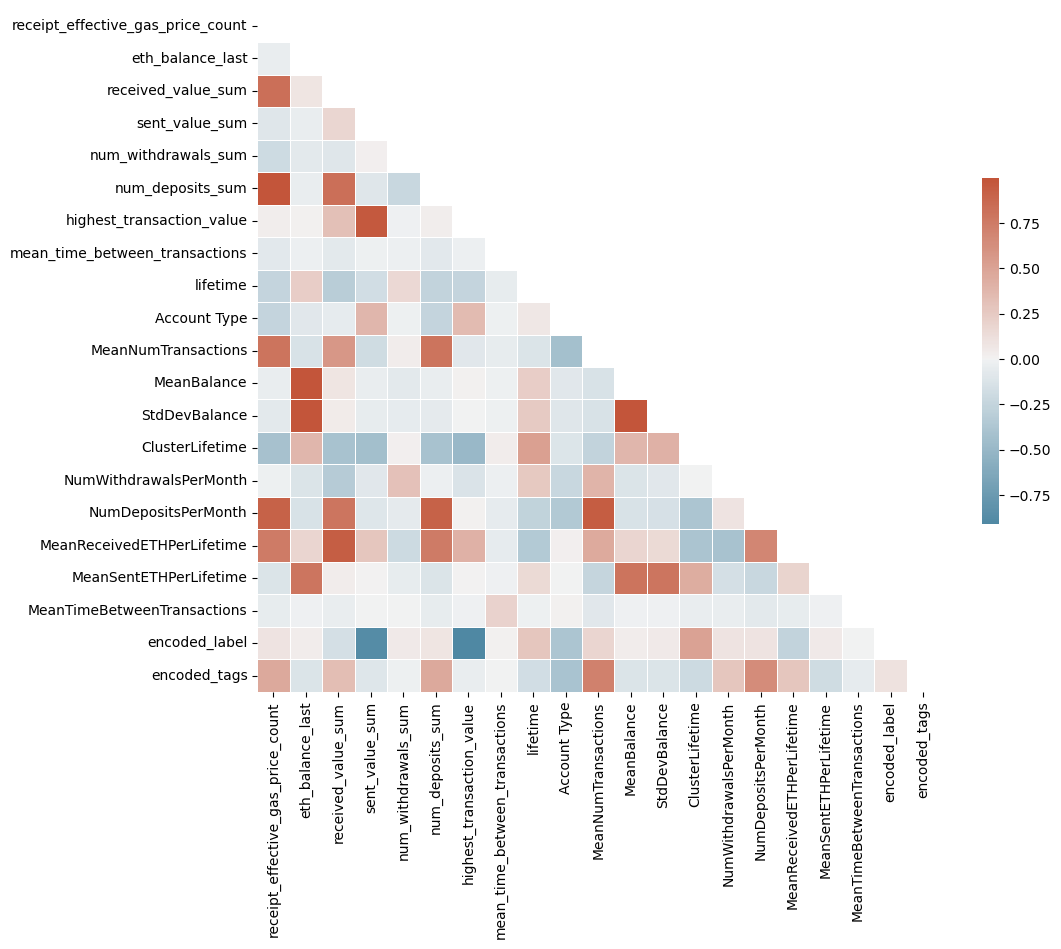

In [49]:
# plt.figure(figsize=(15,15))
# sns.heatmap(data.select_dtypes(include='number').corr(), annot=True, fmt=".2f")
# plt.show()

# One-hot encode the 'Label' column
df_encoded = data #pd.get_dummies(data, columns=['Label'])

# Calculate correlation matrix
corr = df_encoded.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

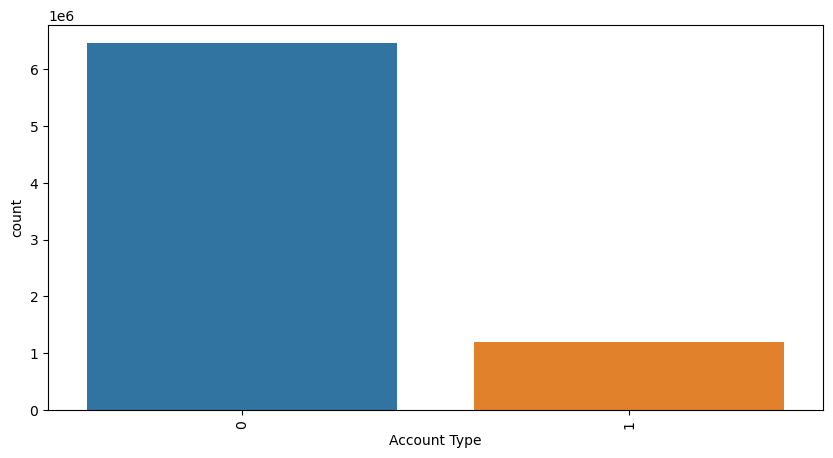

Account Type 1 is Wallet, Type 0 is Smart Contract


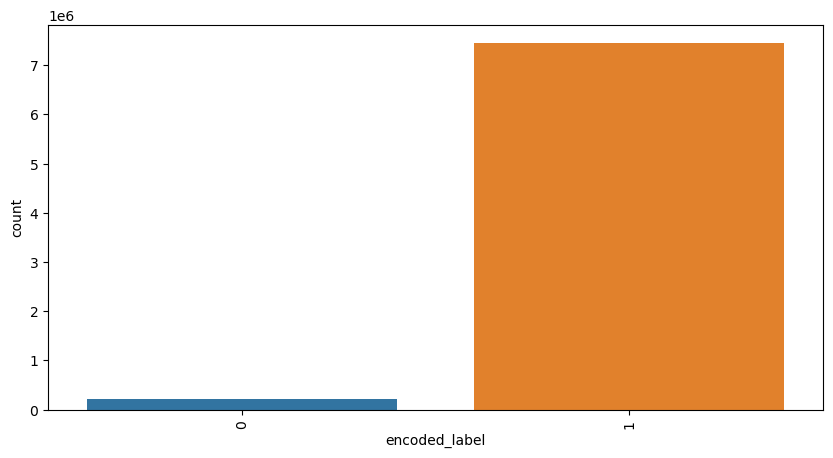

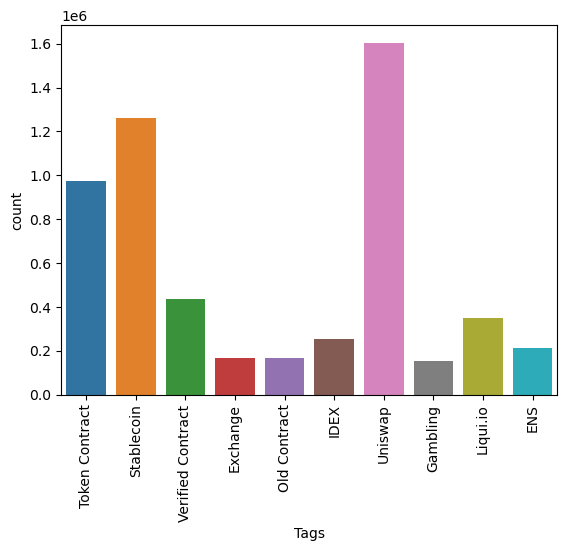

In [50]:
def plot_bar(column):
    plt.figure(figsize=(10,5))
    sns.countplot(data=data, x=column)
    plt.xticks(rotation=90)  # Rotate x-axis labels for readability
    plt.show()

plot_bar('Account Type')
print ("Account Type 1 is Wallet, Type 0 is Smart Contract")
plot_bar('encoded_label')

# Wayyyy to many tags (250+) so we have to settle at most common tags
top_n = 10
top_tags = data['Tags'].value_counts().index[:top_n]
df_top_tags = data[data['Tags'].isin(top_tags)]

sns.countplot(data=df_top_tags, x='Tags')
plt.xticks(rotation=90)
plt.show()

Encoded Label 0 is Dodgy, 1 is Legit

Also based on the chart at near end of this file, Token Contract, Stablecoin and Uniswap transactions volume completely outnumbers the WHOLE ~250 tags

# BASED ON THE COUNT, many tags occurred below 10. In fact, the calculation there also say cut off rate is 9.8 .Thus, those count below 10 will be treated as NOISE

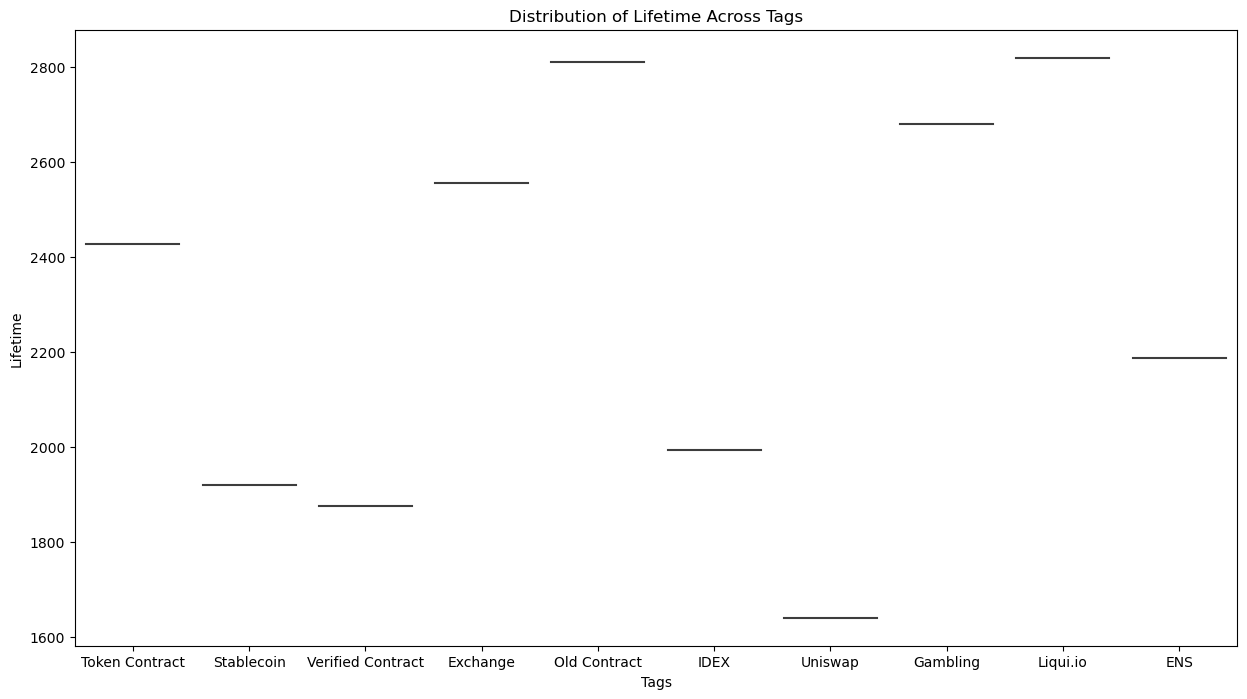

In [51]:
# Filter data for top_tags
filtered_data = data[data['Tags'].isin(top_tags)]

plt.figure(figsize=(15, 8))  # You can adjust the size to fit your needs
sns.violinplot(x='Tags', y='ClusterLifetime' , data=filtered_data)
plt.title('Distribution of Lifetime Across Tags')
plt.xlabel('Tags')
plt.ylabel('Lifetime')
plt.show()

# sns.barplot(x='Label', y='ClusterLifetime', data=data, estimator=np.mean)
# plt.title('Average Lifetime for Each Tag')
# plt.xlabel('Label')
# plt.ylabel('Average Lifetime')
# plt.show()

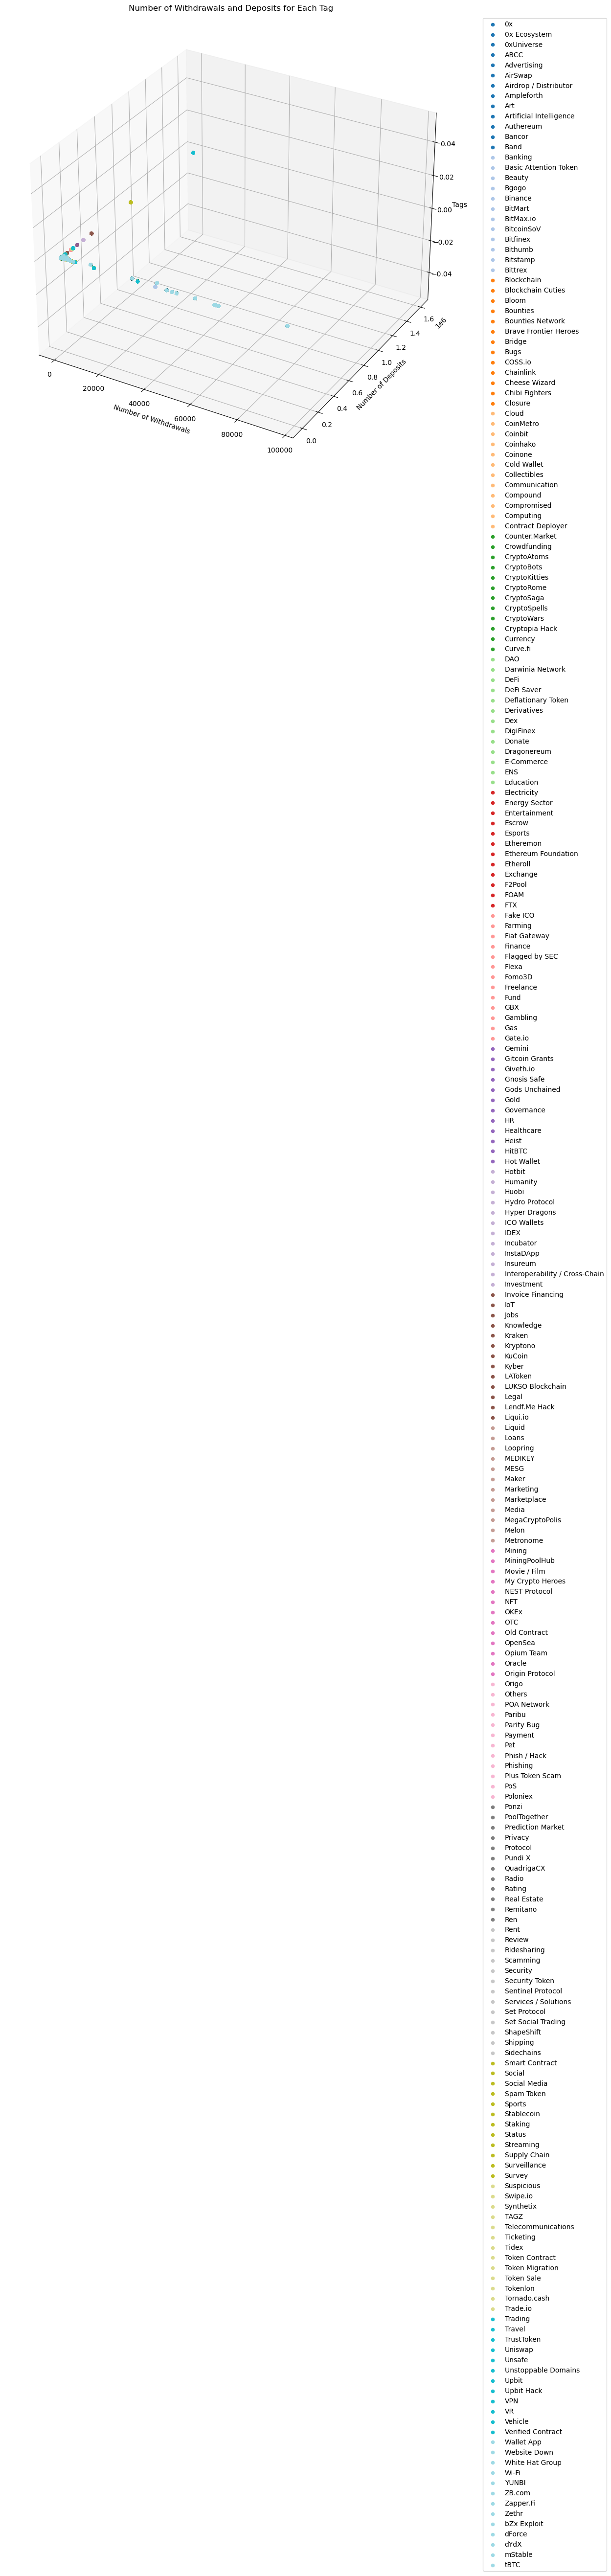

In [53]:
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# # Select only the relevant columns and drop missing values
# df_reduced = data[['num_withdrawals_sum', 'num_deposits_sum', 'Tags']].dropna()

# # Ensure your 'Tags' column is of type 'category' for proper color mapping
# df_reduced['Tags'] = df_reduced['Tags'].astype('category')

# # Create a colormap
# colors = plt.get_cmap('tab20', lut=len(df_reduced['Tags'].cat.categories)) 

# fig = plt.figure(figsize=(12, 12))  # Increase figure size
# ax = fig.add_subplot(111, projection='3d')

# # Plot each tag
# for tag in df_reduced['Tags'].cat.categories:
#     tag_data = df_reduced[df_reduced['Tags'] == tag]
#     ax.scatter(tag_data['num_withdrawals_sum'], tag_data['num_deposits_sum'], zs=0, zdir='z', s=20, depthshade=True, label=tag, color=colors(tag))

# # # Format y-axis labels
# # formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
# # ax.xaxis.set_major_formatter(formatter)
    
# ax.set_xlabel('Number of Withdrawals')
# ax.set_ylabel('Number of Deposits')
# ax.set_zlabel('Tags')
# plt.title('Number of Withdrawals and Deposits for Each Tag')

# # Place the legend to the right of the plot
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.savefig('cluster_withdraws_deposits.png')
# plt.show()
# Select only the relevant columns and drop missing values
df_reduced = data[['num_withdrawals_sum', 'num_deposits_sum', 'Tags']].dropna()

# Ensure your 'Tags' column is of type 'category' for proper color mapping
df_reduced['Tags'] = df_reduced['Tags'].astype('category')

# Create a colormap
colors = plt.get_cmap('tab20', lut=len(df_reduced['Tags'].cat.categories))

# Create a mapping from tags to indices
tag_to_index = {tag: index for index, tag in enumerate(df_reduced['Tags'].cat.categories)}

fig = plt.figure(figsize=(12, 12))  # Increase figure size
ax = fig.add_subplot(111, projection='3d')

# Plot each tag
for tag in df_reduced['Tags'].cat.categories:
    tag_data = df_reduced[df_reduced['Tags'] == tag]
    ax.scatter(tag_data['num_withdrawals_sum'], tag_data['num_deposits_sum'], zs=0, zdir='z', s=20, depthshade=True, label=tag, color=colors(tag_to_index[tag]))

# Format x-axis labels
formatter = FuncFormatter(lambda x, pos: '{:.0f}'.format(x))
ax.xaxis.set_major_formatter(formatter)    
  
ax.set_xlabel('Number of Withdrawals')
ax.set_ylabel('Number of Deposits')
ax.set_zlabel('Tags')
plt.title('Number of Withdrawals and Deposits for Each Tag')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.savefig('cluster_withdraws_deposits.png')
plt.show()

Based on the color, it seems most activities are mostly from 204 onward (after Stablecoin)

In [58]:
cluster_tags = [i for i in range(204,248)]
for tag_encoded in cluster_tags:
    original_tag = encoder_tags.inverse_transform([tag_encoded])
    print("tag_encoded " + str(tag_encoded) + " is " + str(original_tag[0]))

tag_encoded 204 is Stablecoin
tag_encoded 205 is Staking
tag_encoded 206 is Status
tag_encoded 207 is Streaming
tag_encoded 208 is Supply Chain
tag_encoded 209 is Surveillance
tag_encoded 210 is Survey
tag_encoded 211 is Suspicious
tag_encoded 212 is Swipe.io
tag_encoded 213 is Synthetix
tag_encoded 214 is TAGZ
tag_encoded 215 is Telecommunications
tag_encoded 216 is Ticketing
tag_encoded 217 is Tidex
tag_encoded 218 is Token Contract
tag_encoded 219 is Token Migration
tag_encoded 220 is Token Sale
tag_encoded 221 is Tokenlon
tag_encoded 222 is Tornado.cash
tag_encoded 223 is Trade.io
tag_encoded 224 is Trading
tag_encoded 225 is Travel
tag_encoded 226 is TrustToken
tag_encoded 227 is Uniswap
tag_encoded 228 is Unsafe
tag_encoded 229 is Unstoppable Domains
tag_encoded 230 is Upbit
tag_encoded 231 is Upbit Hack
tag_encoded 232 is VPN
tag_encoded 233 is VR
tag_encoded 234 is Vehicle
tag_encoded 235 is Verified Contract
tag_encoded 236 is Wallet App
tag_encoded 237 is Website Down
tag_enc

Sentimental categorize, 1 tag can be both Positive/Negative and Neutral:

Important Note: Bad actors using positive/legit crypto exchanges need more data for analysis. ALSO, bad crypto exchanges like FTX need time to uncover

Positive Tags:
Trading, Travel, TrustToken, Uniswap, Unstoppable Domains, Upbit, VPN, VR, Vehicle, Verified Contract, Wallet App, White Hat Group, Wi-Fi, YUNBI, ZB.com, Zapper.Fi, dYdX, mStable, tBTC

Neutral Tags:
Vehicle, VR, VPN, Unstoppable Domains, TrustToken, Trading, Travel, Zapper.Fi, ZB.com, YUNBI, Wallet App, Wi-Fi

Negative Tags:
Unsafe, Upbit Hack, Website Down, bZx Exploit

The tag "nan" does not carry sentiment as it typically stands for Not a Number or missing value in data science terminology.

The ratio calculation becomes:

Positive : Negative : Neutral = 18 : 4 : 12

In [59]:
# # Convert 'MeanTimeBetweenTransactions' to datetime format
# data['MeanTimeBetweenTransactions_frame'] = pd.to_datetime(data['MeanTimeBetweenTransactions'])

# # 1) Time of the day with most transactions
# data['hour'] = data['MeanTimeBetweenTransactions_frame'].dt.hour
# most_transactions_hour = data['hour'].mode()[0]

# Set maximum rows displayed
pd.set_option('display.max_rows', None)
received_value_sum = data.groupby('Tags')['received_value_sum'].mean()

print("\n Receive Value Sum for each tag:")
print (received_value_sum.sort_values(ascending= False))


 Receive Value Sum for each tag:
Tags
Uniswap                           2.186929e+24
Kraken                            1.970759e+24
Plus Token Scam                   1.675644e+24
Heist                             1.668466e+24
Bitfinex                          1.502152e+24
ABCC                              9.667704e+23
Liqui.io                          9.235820e+23
Flagged by SEC                    6.988342e+23
OKEx                              6.777347e+23
Invoice Financing                 6.729333e+23
Gemini                            5.736533e+23
Poloniex                          4.467694e+23
Rating                            3.876970e+23
Social Media                      3.325669e+23
Knowledge                         3.266474e+23
Upbit                             2.780681e+23
LUKSO Blockchain                  2.726952e+23
Derivatives                       2.554076e+23
Basic Attention Token             2.120973e+23
Banking                           1.723582e+23
Protocol             

From this, we can see although the volume of transactions by illegal activities are low, the sum values are massive. For instance: Plus Token Scam, Heist, Flagged by SEC !!!!!!!!

# These code belows are old df with only transaction, RUN WITH CAUTION

In [8]:
data = new_df

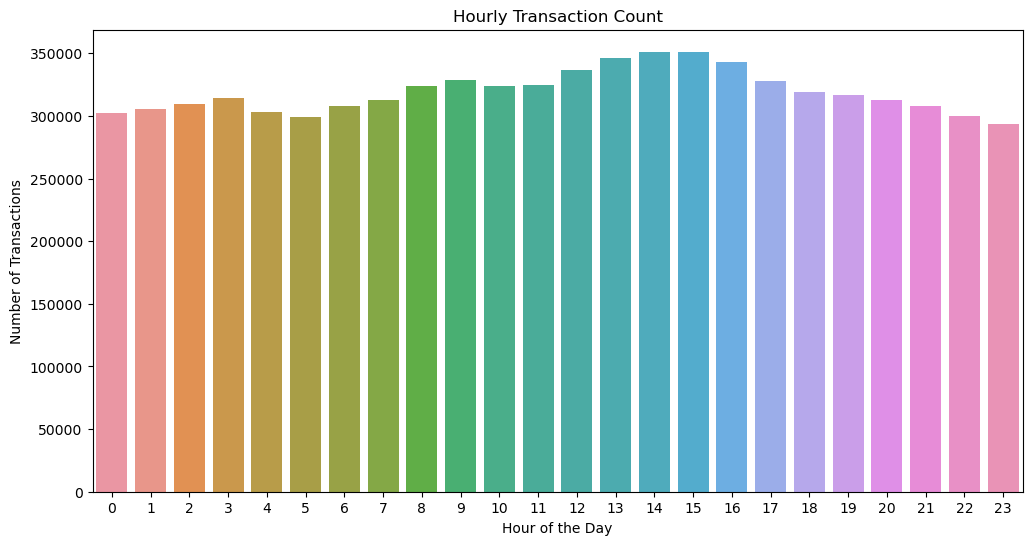

In [10]:
# Convert 'block_timestamp_frame' to datetime format
data['block_timestamp'] = pd.to_datetime(data['block_timestamp'])

# Extract hour from 'block_timestamp'
data['hour'] = data['block_timestamp'].dt.hour

# Count transactions per hour
hourly_transactions = data['hour'].value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_transactions.index, y=hourly_transactions.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.title("Hourly Transaction Count")
plt.show()

In [12]:
# Separate data by label
data_0 = data[data['Label'] == 'Dodgy']
data_1 = data[data['Label'] == 'Legit']

# Count transactions per hour for each label
hourly_transactions_0 = data_0['hour'].value_counts().sort_index()
hourly_transactions_1 = data_1['hour'].value_counts().sort_index()

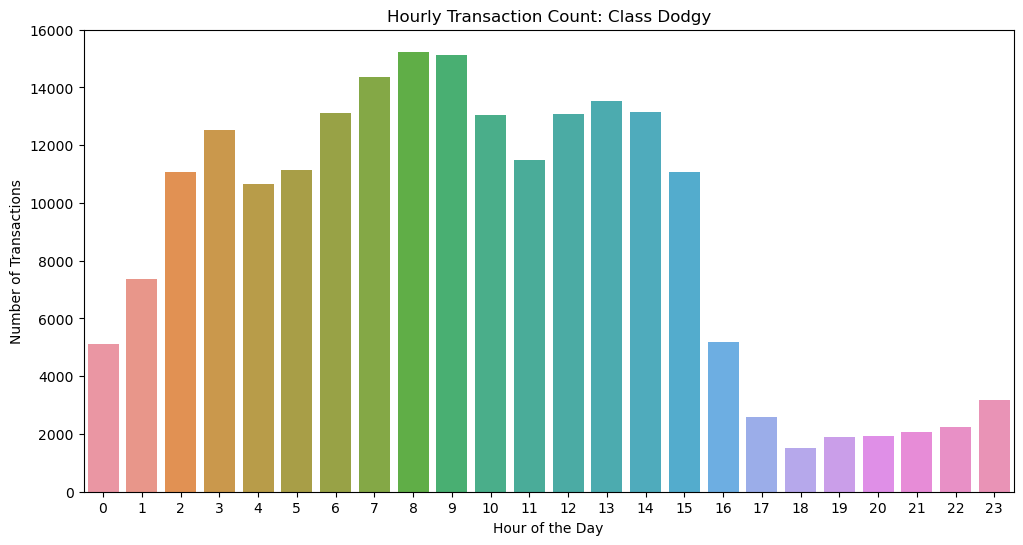

In [13]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_transactions_0.index, y=hourly_transactions_0.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.title("Hourly Transaction Count: Class Dodgy")
plt.show()

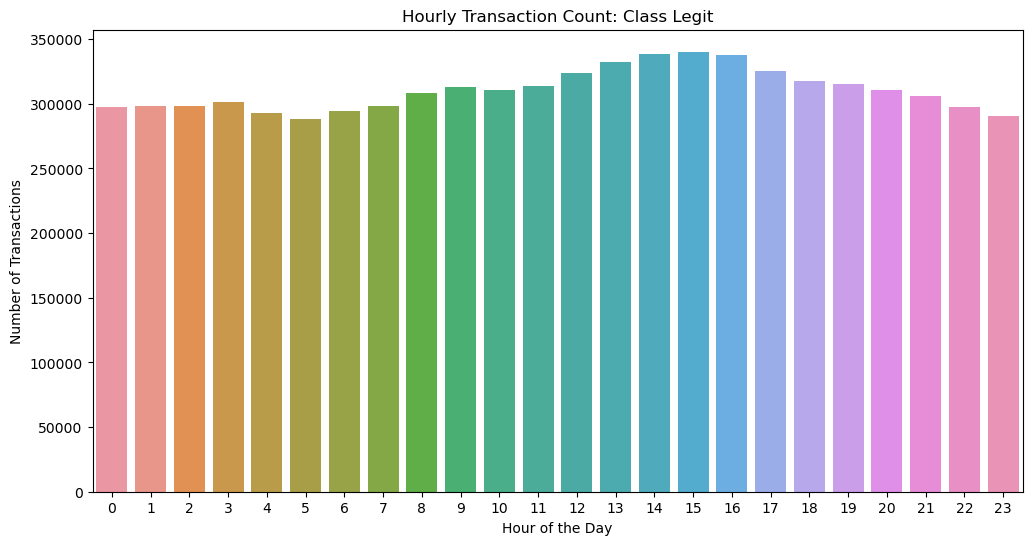

In [14]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=hourly_transactions_1.index, y=hourly_transactions_1.values)
plt.xlabel("Hour of the Day")
plt.ylabel("Number of Transactions")
plt.title("Hourly Transaction Count: Class Legit")
plt.show()

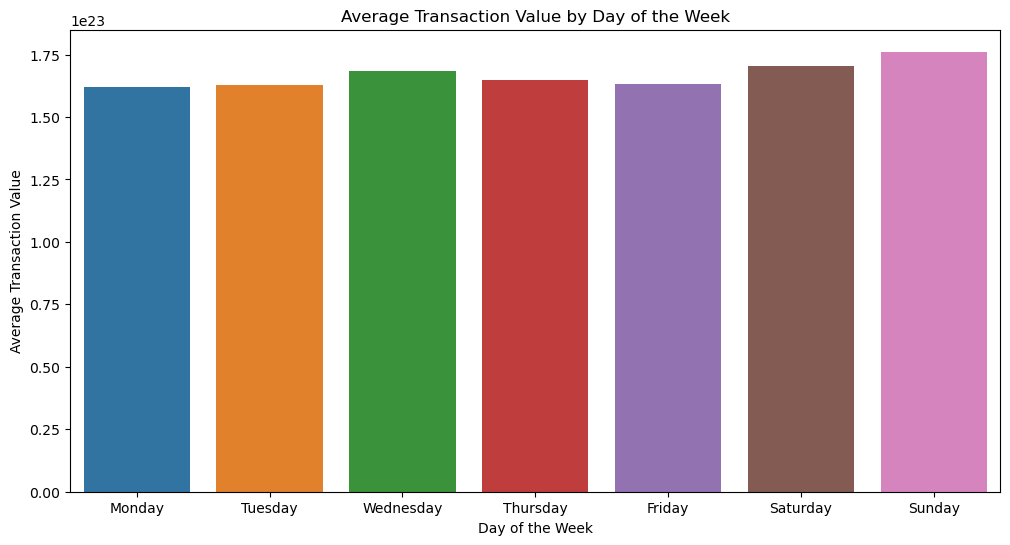

In [16]:
# Convert 'eth_balance_frame' to float
data['eth_balance'] = data['eth_balance'].astype(float)

# Calculate the average transaction value by day of the week
data['day_of_week'] = data['block_timestamp'].dt.day_name()
average_transaction_value_by_day = data.groupby('day_of_week')['eth_balance'].mean()

# Define the order of the days
desired_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']


# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=average_transaction_value_by_day.index, y=average_transaction_value_by_day.values, order=desired_order)
plt.xlabel("Day of the Week")
plt.ylabel("Average Transaction Value")
plt.title("Average Transaction Value by Day of the Week")
plt.show()

In [17]:
# Separate data by label
data_0 = data[data['Label'] == 'Dodgy']
data_1 = data[data['Label'] == 'Legit']

# Count transactions per hour for each label
# Calculate the average transaction value by day of the week
average_transaction_value_by_day_0 = data_0.groupby('day_of_week')['eth_balance'].mean()
average_transaction_value_by_day_1 = data_1.groupby('day_of_week')['eth_balance'].mean()

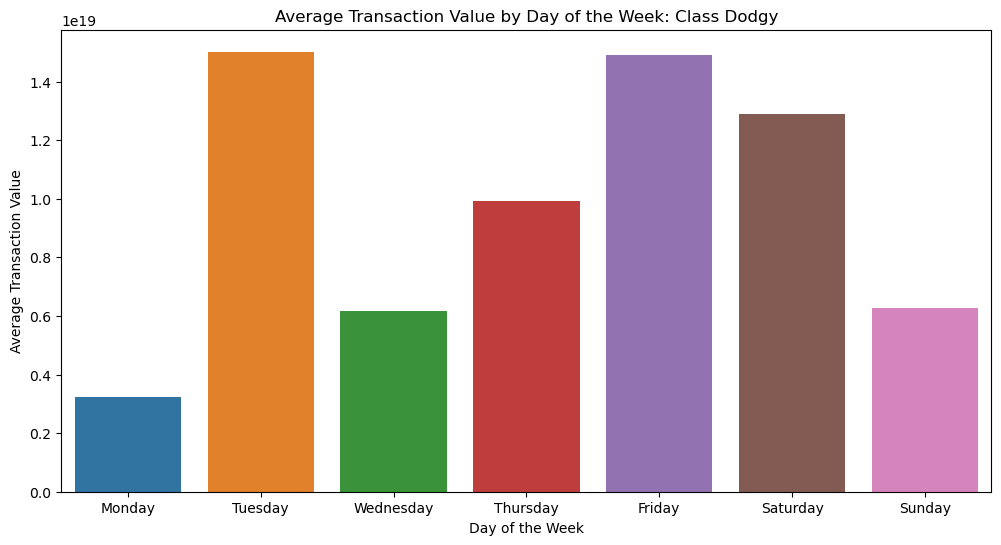

In [18]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=average_transaction_value_by_day_0.index, y=average_transaction_value_by_day_0.values, order=desired_order)
plt.xlabel("Day of the Week")
plt.ylabel("Average Transaction Value")
plt.title("Average Transaction Value by Day of the Week: Class Dodgy")
plt.show()

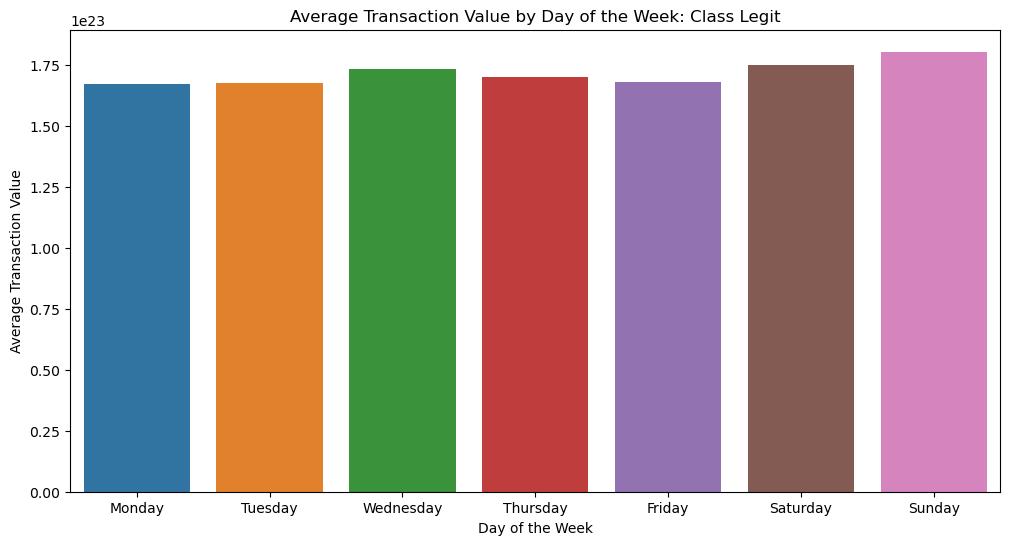

In [19]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=average_transaction_value_by_day_1.index, y=average_transaction_value_by_day_1.values, order=desired_order)
plt.xlabel("Day of the Week")
plt.ylabel("Average Transaction Value")
plt.title("Average Transaction Value by Day of the Week: Class Legit")
plt.show()

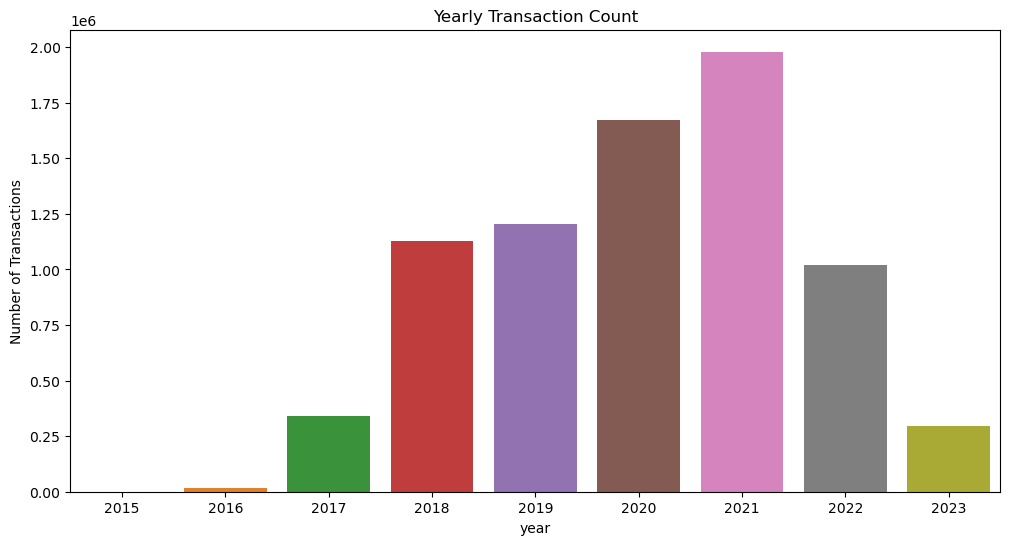

In [20]:
# Extract hour from 'block_timestamp_frame'
data['year'] = data['block_timestamp'].dt.year

# Count transactions per hour
yearly_transactions = data['year'].value_counts().sort_index()

# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_transactions.index, y=yearly_transactions.values)
plt.xlabel("year")
plt.ylabel("Number of Transactions")
plt.title("Yearly Transaction Count")
plt.show()

In [21]:
# Extract hour from 'block_timestamp_frame'
data_0 = data[data['Label'] == 'Dodgy']
data_1 = data[data['Label'] == 'Legit']

# Count transactions per hour
yearly_transactions_0 = data_0['year'].value_counts().sort_index()
yearly_transactions_1 = data_1['year'].value_counts().sort_index()

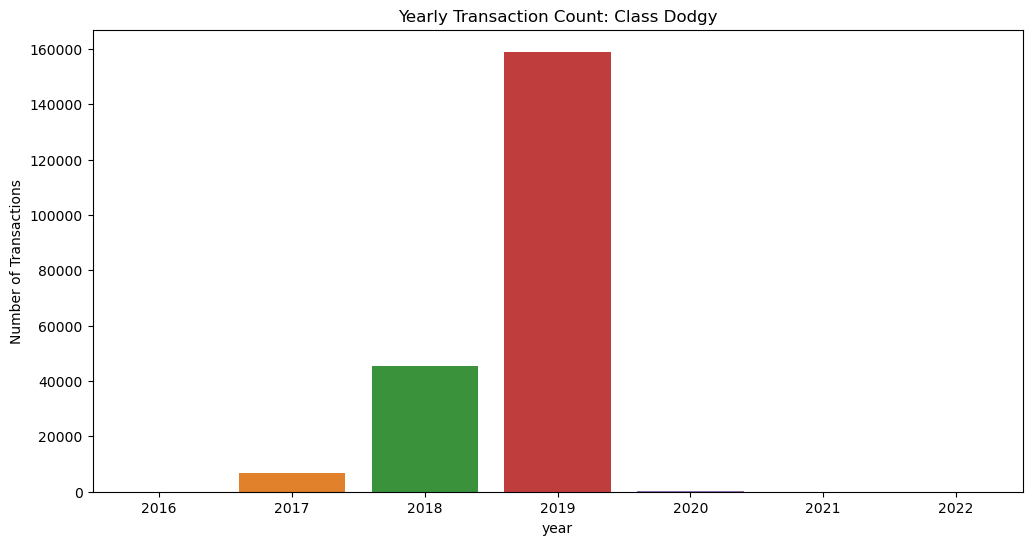

In [22]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_transactions_0.index, y=yearly_transactions_0.values)
plt.xlabel("year")
plt.ylabel("Number of Transactions")
plt.title("Yearly Transaction Count: Class Dodgy")
plt.show()

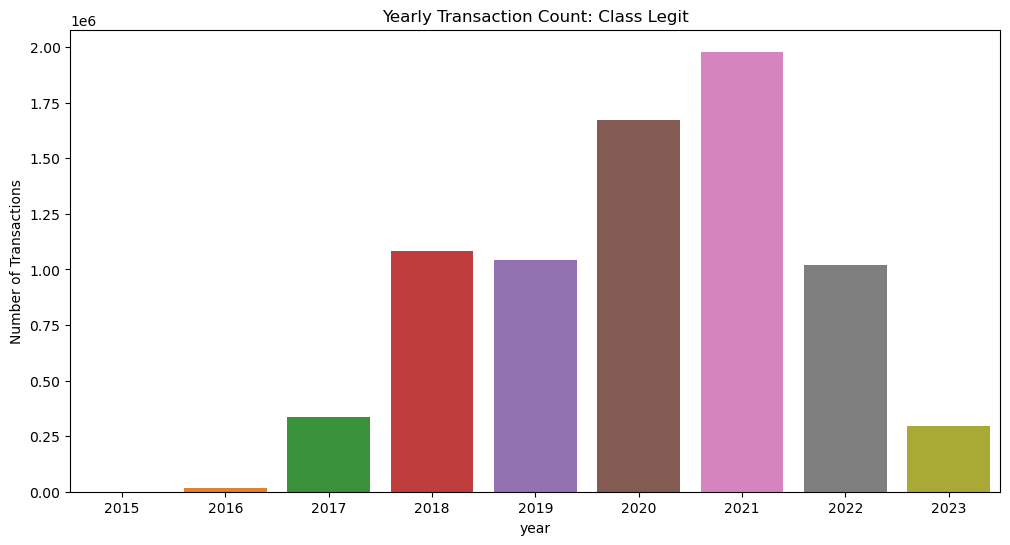

In [23]:
# Plot the bar graph
plt.figure(figsize=(12, 6))
sns.barplot(x=yearly_transactions_1.index, y=yearly_transactions_1.values)
plt.xlabel("year")
plt.ylabel("Number of Transactions")
plt.title("Yearly Transaction Count: Class Legit")
plt.show()

Using new_df at top

In [14]:
new_df.columns

Index(['Account Type', 'Label', 'Tags', 'value', 'gas', 'block_timestamp',
       'receipt_cumulative_gas_used', 'receipt_effective_gas_price', 'address',
       'from_address', 'to_address', 'eth_balance'],
      dtype='object')

C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\769995094.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_0['value_frame_bins'] = pd.qcut(data_0['value_frame'], q=50, duplicates='drop')
C:\Users\vieth\AppData\Local\Temp\ipykernel_20180\769995094.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_1['value_frame_bins'] = pd.qcut(data_1['value_frame'], q=50, duplicates='drop')


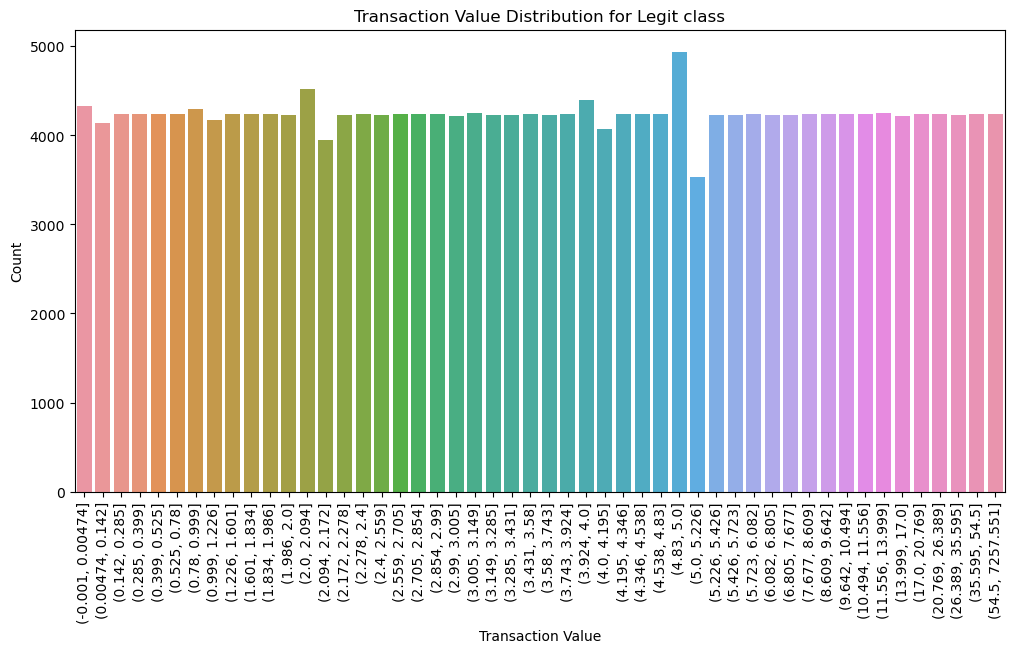

In [18]:
# Convert 'value_frame' to float
data = new_df
data['value_frame'] = data['value'].astype(float)
data['eth_balance_frame'] = data['eth_balance'].astype(float)
# Convert from wei to ETH
data['value_frame'] = data['value_frame'] / 1e18
data['eth_balance_frame'] = data['eth_balance_frame'] / 1e18


# Separate data by label
data_0 = data[data['Label'] == 'Dodgy']
data_1 = data[data['Label'] == 'Legit']

# Create bins for 'value_frame' column
data_0['value_frame_bins'] = pd.qcut(data_0['value_frame'], q=50, duplicates='drop')
data_1['value_frame_bins'] = pd.qcut(data_1['value_frame'], q=50, duplicates='drop')

# # Remove duplicates from 'value_frame_bins' for each label
# unique_data_0 = data_0.drop_duplicates(subset=['value_frame_bins'])
# unique_data_1 = data_1.drop_duplicates(subset=['value_frame_bins'])

# Plot the histogram for label 0
plt.figure(figsize=(12, 6))
sns.countplot(data=data_0, x='value_frame_bins')
plt.xlabel("Transaction Value")
plt.ylabel("Count")
plt.title("Transaction Value Distribution for Legit class")
plt.xticks(rotation=90)  # To make x-axis labels readable
plt.show()

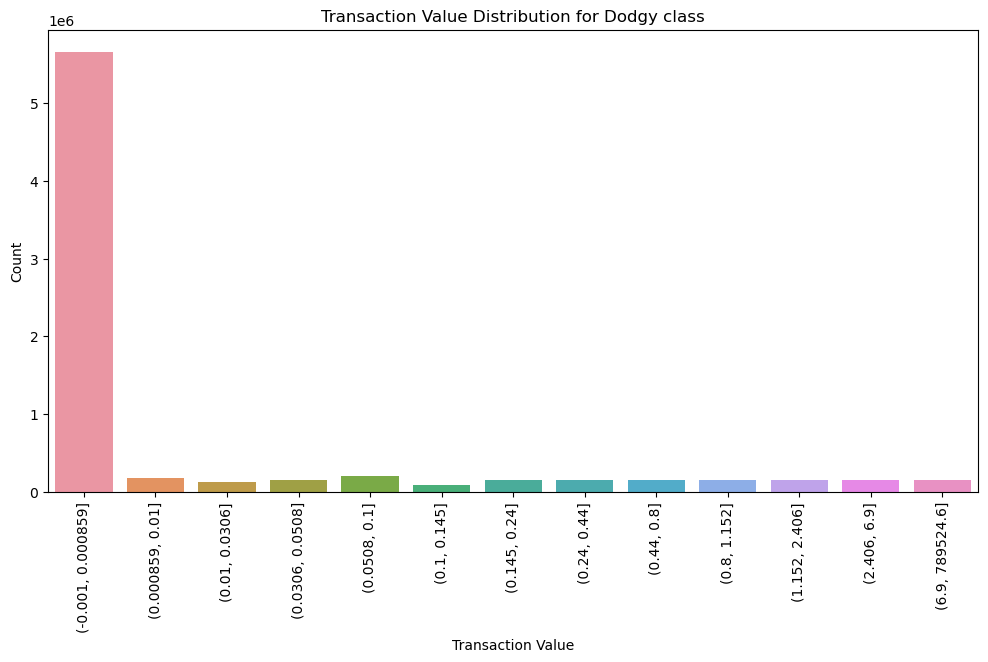

In [19]:
# Plot the histogram for label 1
plt.figure(figsize=(12, 6))
sns.countplot(data=data_1, x='value_frame_bins')
plt.xlabel("Transaction Value")
plt.ylabel("Count")
plt.title("Transaction Value Distribution for Dodgy class")
plt.xticks(rotation=90)  # To make x-axis labels readable
plt.show()

In [61]:
print ("Data tags distribution check")
tags_dict = dict()
for row in tqdm(processed_data.iterrows()):
#     print (row[1]['Label'])
    tag_val = row[1]['encoded_tags']
    if tag_val not in tags_dict.keys():
        tags_dict[tag_val] = 1
    else:
        tags_dict[tag_val] += 1
        
print ("----------------------------")
print ("The average occurence: ")
counts = list(tags_dict.values())
print (sum(counts)/len(counts))

Data tags distribution check


7660778it [03:14, 39426.69it/s]

----------------------------
The average occurence: 
30643.112


In [62]:
# Compute the 10th percentile of the counts
cutoff = np.percentile(list(tags_dict.values()), 10)

print(f"Cutoff value: {cutoff}")

# Filter out tags considered as 'noise'
filtered_tags_dict = {k: v for k, v in tags_dict.items() if v > cutoff}

print(f"Filtered tags dict: {filtered_tags_dict}")

Cutoff value: 9.800000000000004
Filtered tags dict: {218: 972584, 68: 89442, 226: 1153, 204: 1262451, 235: 434742, 169: 1490, 104: 7418, 149: 196, 81: 57, 220: 33423, 236: 94799, 117: 1317, 170: 254, 189: 856, 83: 168059, 131: 50781, 157: 167633, 48: 48840, 14: 17341, 176: 34467, 11: 23286, 49: 158, 166: 142, 23: 82810, 142: 45141, 101: 620, 64: 63710, 9: 30175, 85: 911, 153: 241, 7: 8435, 106: 198, 4: 14599, 105: 3299, 199: 29435, 118: 255184, 125: 7146, 67: 66772, 233: 54516, 178: 11108, 151: 1254, 144: 26303, 66: 420, 123: 8266, 46: 1341, 180: 5339, 188: 2019, 237: 7679, 34: 1854, 77: 9292, 57: 2223, 114: 69726, 191: 95, 194: 1326, 95: 197, 130: 42025, 227: 1604939, 38: 70603, 172: 41662, 26: 12303, 65: 10, 25: 1789, 246: 316, 224: 1349, 181: 1001, 71: 900, 208: 3530, 97: 155289, 62: 42615, 17: 32515, 124: 1297, 76: 8626, 91: 298, 200: 14902, 127: 766, 203: 39925, 213: 38757, 196: 2099, 44: 17343, 5: 12, 158: 45239, 136: 350691, 79: 173, 231: 121, 103: 58, 1: 28621, 73: 214258, 132:

***DEFENDING CUTTING OFF BOTTOM 10 PERCENTILES INSTEAD OF CALCULATING LOWER FENCE***

   - Top 10 most active tags are trading platform and smart contracts, as seen above, so no upper fence.
   - From the chart below, it is clear that the distribution is heavily left skewed. Lower fence will cut off first 25 percentiles, which can included triple digit occurences. This will loose many learning data.

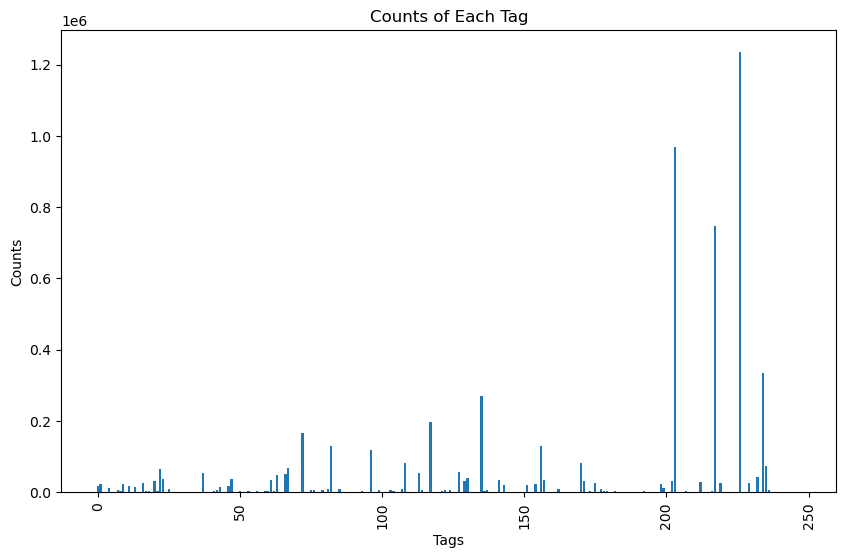

In [12]:
# import matplotlib.pyplot as plt

# # Split keys and values
# tags = list(tags_dict.keys())
# counts = list(tags_dict.values())

# # Create bar chart
# plt.figure(figsize=(10,6))  # Optional: Adjust the size to your needs
# plt.bar(tags, counts)

# # Labels
# plt.xlabel('Tags')
# plt.ylabel('Counts')
# plt.title('Counts of Each Tag')

# # Optional: Rotate x-axis labels if they overlap
# plt.xticks(rotation=90)

# plt.show()

** Binary Classification Code

In [2]:
# from datetime import datetime

# processed_data = pd.read_csv('./temp/50_50_balanced_data.csv')

# # split the string column into separate features
# def split_string(text):
#     features = text.split(',')
#     for i in range(len(features)):
#         if i == 0 or i == 1:
#             if features[i] != 'nan':
#                 timestamp = datetime.strptime(features[i], '%Y-%m-%d %H:%M:%S%z')
#                 features[i] = timestamp.timestamp()
#             else:
#                 features[i] = datetime(2000, 1, 1, 0, 0, 0, tzinfo=None).timestamp()
#         else:
#             features[i] = float(features[i])
#     return features 

# features = processed_data['text'].apply(split_string)
# features

0          [1510826325.0, 1682954975.0, 37318.0, 1.293514...
1          [1528089526.0, 1682813891.0, 3747.0, 0.0, 0.0,...
2          [1536720007.0, 1682960903.0, 623507.0, 0.0, 1....
3          [1527245330.0, 1576716704.0, 160633.0, 1.24271...
4          [1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...
                                 ...                        
5915131    [1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...
5915132    [1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...
5915133    [1528334902.0, 1681798067.0, 13328.0, 0.0, 0.0...
5915134    [1591396246.0, 1682960951.0, 1224650.0, 2.5e+1...
5915135    [1527245330.0, 1576716704.0, 160633.0, 1.24271...
Name: text, Length: 5915136, dtype: object

Detecting some rows have nan value due to oversampling and undersampling.

In [3]:
# processed_data['text'] = features
# processed_data

,text,encoded_label
0,"[1510826325.0, 1682954975.0, 37318.0, 1.293514...",1
1,"[1528089526.0, 1682813891.0, 3747.0, 0.0, 0.0,...",1
2,"[1536720007.0, 1682960903.0, 623507.0, 0.0, 1....",1
3,"[1527245330.0, 1576716704.0, 160633.0, 1.24271...",0
4,"[1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...",1
...,...,...
5915131,"[1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...",0
5915132,"[1498172220.0, 1547441145.0, 26021.0, 0.0, 6.3...",0
5915133,"[1528334902.0, 1681798067.0, 13328.0, 0.0, 0.0...",1
5915134,"[1591396246.0, 1682960951.0, 1224650.0, 2.5e+1...",1


In [4]:
# # Check for NaN and infinite values
# if processed_data.isnull().values.any():
#     print("There are NaN values in the processed_data dataframe")
    
# # # Convert it to float32 for Random Forest library
# # from sklearn.preprocessing import MinMaxScaler

# # # Convert the "text" column to a numpy array
# # text_array = np.array(list(processed_data["text"]))

# # # Scale down the values in the array to the range [0, 1]
# # scaler = MinMaxScaler()
# # text_array_scaled = scaler.fit_transform(text_array)

# # # Cast the scaled array to the float32 data type
# # text_array_scaled = text_array_scaled.astype(np.float32)

# # # Create a new dataframe with the scaled "text" column and the original "encoded_label" column
# # new_df = pd.DataFrame({'text': list(text_array_scaled), 'encoded_label': processed_data['encoded_label']})

# # # Replace the original "processed_data" dataframe with the new dataframe
# # processed_data = new_df

# from sklearn.preprocessing import MinMaxScaler

# # Check for NaN and infinite values
# if processed_data.isnull().values.any():
#     print("There are NaN values in the processed_data dataframe")
    
# # Convert list of lists in text column to DataFrame
# text_df = pd.DataFrame(processed_data['text'].to_list())

# # Replace infinite values with NaN
# text_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Replace NaN with a large number (for example, max float64)
# text_df.fillna(np.finfo(np.float64).max, inplace=True)

# # Scale values using MinMaxScaler
# scaler = MinMaxScaler()
# scaled_values = scaler.fit_transform(text_df)

# # Replace original text column with scaled values
# processed_data['text'] = list(scaled_values)

In [5]:
# processed_data

,text,encoded_label
0,"[0.31510995847369294, 0.9999753040117074, 0.03...",1
1,"[0.39078505406778596, 0.9993922704085749, 0.00...",1
2,"[0.4286176944163529, 0.9999998016386487, 0.509...",1
3,"[0.38708443023793304, 0.5609426572789182, 0.13...",0
4,"[0.2596393301972393, 0.4399605852688051, 0.021...",1
...,...,...
5915131,"[0.2596393301972393, 0.4399605852688051, 0.021...",0
5915132,"[0.2596393301972393, 0.4399605852688051, 0.021...",0
5915133,"[0.39186068611635605, 0.9951943491214834, 0.01...",1
5915134,"[0.6682968601197761, 1.0, 0.9999999999999999, ...",1


In [6]:
# # Check for NaN and infinite values   
# print ('0' if np.isnan(processed_data["text"][5915135]).any() else '1')
# mask = processed_data['text'].apply(lambda x: np.isnan(np.sum(x)))
# new_processed_data = processed_data[~mask]
# new_processed_data

1


,text,encoded_label
0,"[0.31510995847369294, 0.9999753040117074, 0.03...",1
1,"[0.39078505406778596, 0.9993922704085749, 0.00...",1
2,"[0.4286176944163529, 0.9999998016386487, 0.509...",1
3,"[0.38708443023793304, 0.5609426572789182, 0.13...",0
4,"[0.2596393301972393, 0.4399605852688051, 0.021...",1
...,...,...
5915131,"[0.2596393301972393, 0.4399605852688051, 0.021...",0
5915132,"[0.2596393301972393, 0.4399605852688051, 0.021...",0
5915133,"[0.39186068611635605, 0.9951943491214834, 0.01...",1
5915134,"[0.6682968601197761, 1.0, 0.9999999999999999, ...",1


In [7]:
# print ("Data label distribution check")
# labels_dict = dict()
# for row in tqdm(new_processed_data.iterrows()):
# #     print (row[1]['Label'])
#     label_val = row[1]['encoded_label']
#     if label_val not in labels_dict.keys():
#         labels_dict[label_val] = 1
#     else:
#         labels_dict[label_val] += 1
        
# print (labels_dict)

Data label distribution check


5915136it [02:23, 41118.04it/s]

{1: 2957568, 0: 2957568}


In [8]:
# new_processed_data.to_csv("./temp/non_nan_balanced_data.csv", index=False)